# SPRINT PROYECT 2

In [130]:
# Importing required libraries.
import pandas as pd
import numpy as np
import scipy as sp

import seaborn as sns #visualisation
import matplotlib.pyplot as plt #visualisation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error

In [131]:
#cargamos el dataset
df = pd.read_csv("DS_Proyecto_01_Datos_Properati.csv")

Se descartan las features start_date,end_date,created_on, lat, lon ya que como vimos en el sprint 1 tenian un valor muy bajo de correlación con el precio.

In [132]:
lista_drop = ['start_date','end_date','created_on', 'lat', 'lon']
df.drop(lista_drop, axis=1, inplace=True)

In [133]:
#¿Qué tamaño tiene el dataset?¿Cuántas instancias y cuántas columnas?
# tiene 146660 líneas y 19 columnas
df.shape

(146660, 14)

# **Transformacion de Datos**

A diferencia del sprint 1, no se descartaran barrios ni zonas, tampoco los tipos de propiedades. Con esto intentaremos mejorar la precisión de nuestros modelos.

- Valores Faltantes: Creamos una columna dummy por cada columna con variable categórica con valores null o nan para saber cuales fueron imputadas. Esto lo hacemos para luego poder identificar los valores que fueron imputados y aplicar filtros a partir de ellas.
- Imputación de valores faltantes: para la variable bathrooms se considera que para ciertos tipos de propiedad, por lo menos tienen un baño (valor de la media), entonces se imputa con 1 u 0 dependiendo el caso. 
Las variables surface_covered y surface_total observamos los casos en que haya faltantes en ambos y se los imputa por la media de cada tipo de propiedad. Para el resto de los faltantes se los imputa con el valor de la otra variable considerando siempre que surface_total >= surface_covered
- Detección y eliminación de Outliers
Se obtienen las estadísticas de surface_covered, surface_total y price para ver el alcance de cada variable y entender si los mínimos y máximos son valores razonables ya que tenemos cierto conocimiento de la información analizada.<br>Como la distribución no es normal, elegimos obtener los límites para eliminar los outliers con el rango intercuartilico. También hacemos un ajuste manual de los límites ya que tenemos cierto conocimiento sobre la matería o datos analizados.

- Encoding: Se selecciona las columnas categóricas que consideramos relevantes para luego convertirlas, como son variables nominales usamos get_dummies() de pandas. Aunque se aumenta la dimensionalidad, lo intentaremos compensar con PCA.

- Escalado de Datos: Utilizamos Z-score para normalizar o estandarizar los datos, que es una medida de cuánto se desvía un valor del promedio, medido en desviaciones estándar. Esto solo lo aplicamos sobre las variables que no son binarias.

- Generación de nuevas variables predictoras/reducción de la dimensionalidad con PCA: Se elige PCA porque nos permite obtener una nueva matríz de correlación usada para el módelo y determinar que tan bien explica la varianza de nuestros datos, pudiendo aplicar una reducción de la dimensionalidad sin perder tanta info y teniendo el control.

#### **Valores Faltantes e Imputaciones**
Creamos una columna dummy por cada columna con variable categórica con valores null o nan para saber cuales fueron imputadas. Esto lo hacemos para luego poder identificar los valores que fueron imputados.

Para imputar la variable `bathrooms` se toma el criterio de que las propiedades habitables por lo menos deberían tener un baño, con lo cual se la imputa con el valor 1 (mediana), y el resto de las propiedades con valor 0.

Para los valores de `surface_total` y `surface_covered` detectamos en los casos en que el valor faltante es una de ellas por instancia, y usamos el valor de una u otra para imputar la faltante. En el caso de que la faltante por instancia sea en ambas, se utilizará el valor de la mediana según el tipo de propiedad.

In [134]:
#detectamos los faltantes.
df.isna().sum()

l1                     0
l2                     0
l3                     0
rooms                  0
bedrooms               0
bathrooms           5957
surface_total      20527
surface_covered    21614
price                  0
currency               0
title                  0
description            0
property_type          0
operation_type         0
dtype: int64

Se crean columnas dummy para cada variable que vamos a imputar, así dejarlas identificadas las imputadas ya que nos puede ser útil más adelante. Es decir que tendrán 1 las imputadas y 0 las que no.

In [135]:
df['dummy_bathrooms'] = 0
df['dummy_surface_total'] = 0
df['dummy_surface_covered'] = 0

In [136]:
df['dummy_surface_total'] = df['surface_total'].apply(lambda x: '1' if (str(x) == 'nan') else '0')
df['dummy_bathrooms'] = df['bathrooms'].apply(lambda x: '1' if (str(x) == 'nan') else '0')
df['dummy_surface_covered'] = df['surface_covered'].apply(lambda x: '1' if (str(x) == 'nan') else '0')

In [137]:
#df['dummy_bathrooms'] = df['bathrooms'].apply(lambda x: '1' if (str(x) == 'nan') else '0')
print("Variable nan que deberia imputarse como 1 en la columna dummy",df['dummy_bathrooms'].iloc[351])  #sabemos que es nan, deberia imputarse como 1
print("Variable No nan que deberia imputarse como 0 en la columna dummy",df['dummy_bathrooms'].iloc[1])     #sabemos que no es nan, debería imputarse como 0

Variable nan que deberia imputarse como 1 en la columna dummy 1
Variable No nan que deberia imputarse como 0 en la columna dummy 0


In [138]:
df['dummy_surface_total'].value_counts()

0    126133
1     20527
Name: dummy_surface_total, dtype: int64

In [139]:
df['dummy_surface_covered'].value_counts()

0    125046
1     21614
Name: dummy_surface_covered, dtype: int64

In [140]:
df['dummy_bathrooms'].value_counts()

0    140703
1      5957
Name: dummy_bathrooms, dtype: int64

In [141]:
df.shape

(146660, 17)

#### Vamos a imputar los valores faltantes de `bathrooms`

De los 146660 hay 5957 instancias con valores nan en bathrooms. Vamos a determinar de esas cuantas corresponden a cada tipo de propiedad

Imputamos con 1 los tipos de propiedades que se suponen que deben tener un baño como mínimo por normativa:
- Departamento
- PH
- Casa
- Oficina
- Local comercial
- Casa de campo

Para el resto de propiedades, imputamos la variable bathrooms con 0

- Lote
- Otro
- Cochera
- Depósito

In [142]:
## Valores not null. Creamos un dataframe con los valores no nulos
filtered_bathrooms_not_nan = df[df['bathrooms'].notnull()]
#filtered_bathrooms_not_nan.head()
filtered_bathrooms_not_nan.shape

(140703, 17)

In [143]:
#valores Null. Creamos dataframe con los valores nulos para trabajarlos
#filtered_df = df[df['var2'].isnull()]
filtered_bathrooms_nan = df[df['bathrooms'].isnull()]
#filtered_bathrooms_nan.head()
filtered_bathrooms_nan.shape

(5957, 17)

In [144]:
# Realizamos una copia del dataframe original
df1= df.copy()

In [145]:
# Realizamos una copia del dataframe que contiene nulos en la feature bathrooms
df2 = filtered_bathrooms_nan.copy()
#df2.shape

Vemos la distribucion la de variable bathrooms para ver como vamos a imputar

In [146]:
dfx = filtered_bathrooms_not_nan.copy()
lista = ['Departamento','PH','Casa','Oficina','Local comercial','Casa de campo']
dfx = dfx[dfx.property_type.isin(lista)]

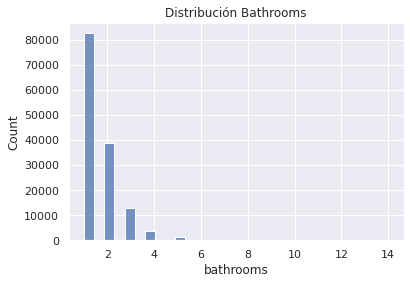

In [147]:
#muestra  = dfx[(dfx['bedrooms'] >4)].bedrooms
muestra = dfx.bathrooms
sns.histplot(dfx.bathrooms, bins = 30, label = 'bedrooms').set_title("Distribución Bathrooms")
plt.show()

Corroboramos la suposición anterior de imputar con el valor 1, que es el valor de la mediana.

In [148]:
dfx.bathrooms.median()

1.0

Filtramos los tipos de propiedades que vamos a imputar con 1, es decir que por lo menos deberían tener un baño.

In [149]:
lista = ['Departamento','PH','Casa','Oficina','Local comercial','Casa de campo']
df3 = df2[df2.property_type.isin(lista)]
df3.head(1)

,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type,dummy_bathrooms,dummy_surface_total,dummy_surface_covered
351,Argentina,Capital Federal,Congreso,1.0,1.0,NaN,23.0,23.0,72000.0,USD,VENTA MONOAMBIENTE CONGRESO EXCELENTE ESTADO,Corredor Responsable: Damian Perrone - CUCICBA...,Departamento,Venta,1,0,0


Determinamos que 4515 instancias corresponden a los tipos de propiedad: 'Departamento','PH','Casa','Oficina','Oficina','Local comercial','Casa de campo' tienen valores nulos o NaN en la feature bathrooms.

In [150]:
#df3.property_type.unique()
df3.shape

(4515, 17)

In [151]:
df3.bathrooms.isnull().sum()
#df3.bathrooms.isnull()

4515

Rellenamos esas instancias con 1

In [152]:
df3 = df3.copy()
df3.loc[:,'bathrooms'] = '1' 
#df3['bathrooms']

In [153]:
#df3.head()

In [154]:
#Controlamos que no haya más nulos
df3.bathrooms.isnull().sum()

0

Ahora rellenamos las instancias para otro tipos de propieadades: 'Lote','Otro','Cochera','Depósito' con valor "0"

In [155]:
lista = ['Lote','Otro','Cochera','Depósito']
df4 = df2[df2.property_type.isin(lista)]
#df4.head(1)

Determinamos que 1442 instancias corresponden a los tipos de propiedad: 'Departamento','PH','Casa','Oficina','Oficina','Local comercial','Casa de campo'

In [156]:
df4.bathrooms.isnull().sum()

1442

Rellenamos las instancias con 0

In [157]:
df4 = df4.copy()
df4.loc[:,'bathrooms'] = '0' 
#df4['bathrooms']

Se observa que hay instancias que no tienen sentido: de los tipos de propiedad de la lista = ['Lote','Otro','Cochera','Depósito']. Estas no deberían tener datos en bedrooms, con lo cual vamos a imputar estos dipos de propiedades la feature bedrooms con 0

In [158]:
df4 = df4.copy()
df4.loc[:,'bedrooms'] = '0' 
#df4_drop = df4[(df4.bedrooms >= 1)]
#df4_drop.shape
#df4[['bathrooms','bedrooms']]

In [159]:
#print("Tamaño antes de droppear las instancias en que indican que hay dormitorio en un tipo de propiedad incorrecta",df4.shape[0])
#df4 = df4.drop(df4[df4.bedrooms >= 1].index)
#print("Tamaño después del drop",df4.shape[0])

Concatenamos los valores filtrados como NaN e imputados

In [160]:
# df3 contine los valores de bathrooms imputados con "1" y df4 los imputados con "0"
result = pd.concat([df3, df4])

In [161]:
#Comprobamos ante la concatenación tenga el mismo espacio
result.shape
#result.isnull().sum()

(5957, 17)

In [162]:
# Concatenamos otra vez, ahora los datos imputados "result" y el dataframe sin nulos "filtered_bathrooms_not_nan"
result_total = pd.concat([result, filtered_bathrooms_not_nan])

In [163]:
# Comprobamos el tamaño
result_total.shape

(146660, 17)

#### Vamos a imputar los valores faltantes de `surface_total`

In [164]:
df5 = result_total.copy()
#df5.head(3)

In [165]:
print("Nulos en surface_covered",df5.surface_covered.isnull().sum())
print("Nulos en surface_total  ",df5.surface_total.isnull().sum())
#print("Total                   ", df5.surface_covered.isnull().sum() + df5.surface_total.isnull().sum())

Nulos en surface_covered 21614
Nulos en surface_total   20527


Verificamos si en la misma instancia hay valores nulos tanto de surface_covered como de surface_total, es decir si están correlacionados los valores faltantes de valores nulos.

In [166]:
surface_total_nan =  df5[df5.surface_total.isnull()]
surface_covered_nan = df5[df5.surface_covered.isnull()]

In [167]:
sup_ambos_faltantes = df5[((df5.dummy_surface_total == '1') & (df5.dummy_surface_covered == '1'))]
print("Faltanes ambas superficies",sup_ambos_faltantes.shape[0])

Faltanes ambas superficies 20012


Las instancias en que la superficie total es faltante pero no la cubierta y biseversa:

In [168]:
df_surface_total_nan = df5[((df5.dummy_surface_total == '1') & (df5.dummy_surface_covered == '0'))]
sup_solo_faltantes_surface_total = df_surface_total_nan.shape[0]

In [169]:
#Al revés que lo anterior, ahora las faltantes son la superfice cubierta pero no la total
df_surface_total_nan_2 = df5[((df5.dummy_surface_total == '0') & (df5.dummy_surface_covered == '1'))]
sup_solo_faltantes_surface_covered = df_surface_total_nan_2.shape[0]

In [170]:
print("sup_ambos_faltantes {}, sup_solo_faltantes_surface_total {}, sup_solo_faltantes_surface_covered {}".format(sup_ambos_faltantes.shape[0],sup_solo_faltantes_surface_total, sup_solo_faltantes_surface_covered))
suma_faltantes_sup = sup_ambos_faltantes.shape[0] + sup_solo_faltantes_surface_total + sup_solo_faltantes_surface_covered
print("Suman faltantes Superficie",suma_faltantes_sup)

sup_ambos_faltantes 20012, sup_solo_faltantes_surface_total 515, sup_solo_faltantes_surface_covered 1602
Suman faltantes Superficie 22129


Es decir que hay 22129 instancias faltantes en total, de las cuales 20012 hay faltantes de ambas features y el resto sup_solo_faltantes_surface_total 515, sup_solo_faltantes_surface_covered 1602. Con lo cual a las primeras las podemos imputar con el valor con el valor medio de cada tipo de propiedad y el resto con la superficie total o cubierta según corresponda.

Reemplazamos los valores surface_total en lo que son nulos por surface_covered

In [171]:
### Normalizo los valores en cual la surface_covered > surface_total, haciendo que surface_total = surface_covered
df5.loc[((df5.dummy_surface_total == '1') & (df5.dummy_surface_covered == '0')), 'surface_total'] = df5.surface_covered

In [172]:
### Normalizo los valores en cual la surface_covered > surface_total, haciendo que surface_total = surface_covered
df5.loc[((df5.dummy_surface_total == '0') & (df5.dummy_surface_covered == '1')), 'surface_covered'] = df5.surface_total

Imputamos según el tipo de propiedad con la mediana

In [173]:
df5.property_type.unique()

array(['Departamento', 'Casa', 'Oficina', 'PH', 'Casa de campo',
       'Local comercial', 'Lote', 'Otro', 'Cochera', 'Depósito'],
      dtype=object)

In [174]:
lista_tipos = ['Lote','Otro','Cochera','Depósito','Departamento','PH','Casa','Oficina','Local comercial','Casa de campo']
for tipo_propiedad in lista_tipos:    
    df5.loc[( ((df5.dummy_surface_total == '1') & (df5.dummy_surface_covered == '1') ) &  (df5.property_type == tipo_propiedad)  ), 'surface_total']  = df5[df5['property_type'] == tipo_propiedad].surface_total.median()
    df5.loc[( ((df5.dummy_surface_total == '1') & (df5.dummy_surface_covered == '1') ) &  (df5.property_type == tipo_propiedad)  ), 'surface_covered'] = df5[df5['property_type'] == tipo_propiedad].surface_covered.median()
    print(tipo_propiedad,"Nulos en surface_covered", df5.loc[( ((df5.dummy_surface_total == '1') & (df5.dummy_surface_covered == '1') ) &  (df5.property_type == tipo_propiedad) ) ]['surface_covered'].isnull().sum() )
    print(tipo_propiedad,"Nulos en surface_total", df5.loc[( ((df5.dummy_surface_total == '1') & (df5.dummy_surface_covered == '1') ) &  (df5.property_type == tipo_propiedad) ) ]['surface_total'].isnull().sum() )

Lote Nulos en surface_covered 0
Lote Nulos en surface_total 0
Otro Nulos en surface_covered 0
Otro Nulos en surface_total 0
Cochera Nulos en surface_covered 0
Cochera Nulos en surface_total 0
Depósito Nulos en surface_covered 0
Depósito Nulos en surface_total 0
Departamento Nulos en surface_covered 0
Departamento Nulos en surface_total 0
PH Nulos en surface_covered 0
PH Nulos en surface_total 0
Casa Nulos en surface_covered 0
Casa Nulos en surface_total 0
Oficina Nulos en surface_covered 0
Oficina Nulos en surface_total 0
Local comercial Nulos en surface_covered 0
Local comercial Nulos en surface_total 0
Casa de campo Nulos en surface_covered 0
Casa de campo Nulos en surface_total 0


In [175]:
#comprobamos que se haya imputado los nulls
df5.isnull().sum()

l1                       0
l2                       0
l3                       0
rooms                    0
bedrooms                 0
bathrooms                0
surface_total            0
surface_covered          0
price                    0
currency                 0
title                    0
description              0
property_type            0
operation_type           0
dummy_bathrooms          0
dummy_surface_total      0
dummy_surface_covered    0
dtype: int64

In [176]:
#Observamos el tamaño del dataset
df5.shape

(146660, 17)

Descartamos si hay instancias duplicadas

In [177]:
df5.drop_duplicates(inplace=True)
df5.shape

(116565, 17)

#### Filtramos los casos en que la propiedad cubierta sea menor que la total y normalizamos valores

In [178]:
df6 = df5.copy()

In [179]:
df6.loc[df6['surface_covered'] >= df6.surface_total, 'surface_total'] = df6.surface_covered

In [180]:
#df6['surface_total'].describe()

In [181]:
df6.shape[0]

116565

Eliminamos las features en que todos sus valores son iguales, por ejemplo currency

In [182]:
lista_drop = []
for i in df6.columns:
    #print(i, df6['i'].unique())
    x = df6[i].unique().size
    if x == 1:
        print("--->",i,df6[i].unique().size)  
        lista_drop.append(i)
print(lista_drop)

---> l1 1
---> currency 1
---> operation_type 1
['l1', 'currency', 'operation_type']


In [183]:
df6.drop(lista_drop, axis=1, inplace=True)

In [184]:
df6.shape

(116565, 14)

#### **Valores Atípicos: Detección y eliminación de Outliers**


Se obtienen las estadisticas de surface_covered, surface_total y price para ver el alcance de cada variable y entender si los mínimos y máximos son valores razonables ya que tenemos cierto conocimiento de la información analizada. 

Como la distribución no es normal, elegimos obtener los límites para eliminar los outliers la regla de 1.5*IRQ  +/- q3/q1 según corresponda. Una vez obtenido el límite observamos los datos que quedan fuera (Lo hacemos para los principales tipos de propiedades). Esto es para ver si son outliers o valores extremos, si son muchas instancias lo analizamos, en caso contrario las descartamos. 

También hacemos un ajuste manual de los límites ya que tenemos cierto conocimiento sobre la matería o datos analizados. A diferencia del sprint 1, decidimos no excluir cierto tipos de propiedades.

In [185]:
#Reallizamos una copia del dataset
df7 = df6.copy()

In [186]:
## Creo un nuevo dataframe a partir de las 3 clases más abundantes (Departamento,Cada y PH)
#df7 = df7[(df7.property_type == "Departamento") | (df7.property_type == "Casa") | (df7.property_type == "PH") ]
## Creo otro Dataframe usando ya el filtrado anterior con la de la zona con mayor propiedades
#df7 = df7[(df7.l2 == "Capital Federal")]
## imprimo el tamaño
print("Tamaño dataset ",df7.shape)

Tamaño dataset  (116565, 14)


In [187]:
#df7.head()

Datos Estadísticos para ver que valores abarcan las variables

In [188]:
df7[['rooms','bedrooms','bathrooms','surface_total','surface_covered']].describe()

,rooms,surface_total,surface_covered
count,116565.000000,116565.000000,116565.000000
mean,3.093416,244.144289,147.271286
std,1.467367,2193.158448,1732.627587
min,1.000000,1.000000,1.000000
25%,2.000000,57.000000,50.000000
50%,3.000000,76.000000,65.000000
75%,4.000000,160.000000,119.000000
max,35.000000,193549.000000,193549.000000


Superficie Total surface_total, analisis de distribución y filtrado de outliers

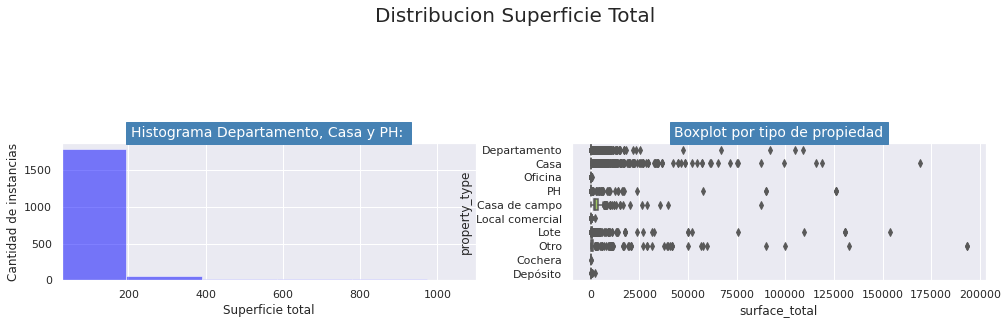

In [189]:
# Creamos la figura y los ejes
fig, axes = plt.subplots(1,2, figsize=(15, 5))
fig.suptitle('Distribucion Superficie Total', fontsize=20)
fig.tight_layout(pad=5.0)

# GRafico 0
muestra1 = df7['surface_total'].value_counts()
axes[0].hist(muestra1, bins = 70, alpha = 0.5, label = 'surface_total', color='blue')
axes[0].set_title("Histograma Departamento, Casa y PH: ",fontsize = 14, color = "w", fontstretch=0, backgroundcolor="SteelBlue")
axes[0].set_xlim([28,1100]) ## limite en x, para acotar y quitar los outliers
axes[0].set_xlabel("Superficie total")
axes[0].set_ylabel("Cantidad de instancias")

#for rect in axes[0].patches:
#    axes[0].text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)

# Gráfico 1
#ax = sns.boxplot(ax=axes[1], data = df7, x = 'property_type', y = "surface_total", orient="v", palette="Set2")
ax = sns.boxplot(ax=axes[1], data = df7, x = 'surface_total', y = "property_type", orient="h", palette="Set2")
axes[1].set_title("Boxplot por tipo de propiedad",fontsize = 14, color = "w", fontstretch=0, backgroundcolor="SteelBlue")
plt.xticks(rotation=0)
plt.show()

La mayoria de los inmuebles tienen superficie menor a 100m2, en la gráfica se observan valores atípicos u outliers que intentaremos deducir a continuación:

In [190]:
df7.surface_total.describe()

count    116565.000000
mean        244.144289
std        2193.158448
min           1.000000
25%          57.000000
50%          76.000000
75%         160.000000
max      193549.000000
Name: surface_total, dtype: float64

Creamos una función para remover los outliers empleando la regla del rango intercuartílico, como se observó en el Sprint 1 la distribución de los precios no era normal.

In [191]:
## Funcion para obtener filtrar los outliers, pasando el dataframe y la columna
def remove_outlier(df_in, col_name,tipo):
    '''
    Dado un dataframe (df_in) devuelve el mismo pero
    filtrado por los límites superiores e inferiores
    según el críterio de los rangos intercuartilicos * 1.5.
    
    Arguments:
    df_in -- dataframe a filtrar
    col_name -- columna por la cual se va a filtrar los datos, valores discretos
    tipo -- tipo de propiedad para filtrar el dataset
    Returns:
    df_out -- dataframe filtrado por tipo de propiedad y límites usando los rango intercuartilicos
    '''
    #dataframe con solo un tipo de propiedad
    df_in_type = df_in[df_in.property_type==tipo]
    q1 = df_in_type[col_name].quantile(0.25)
    q3 = df_in_type[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    limit_low  = q1-1.5*iqr
    limit_high = q3+1.5*iqr
    df_out = df_in_type.loc[(df_in_type[col_name] > limit_low) & (df_in_type[col_name] < limit_high)]
    return df_out, limit_low, limit_high

Obtenemos los límites para cada tipo de propiedad utilizando la función anteriormente creada `remove_outlier` que emplea como límite inferior a q1-1.5\*iqr y el rango superio como q3+1.5\*iqr para todos los tipos de propiedades.

In [192]:
## dataframe filtrado Departamento quitando los datos fuera de los límites de 1.5*IQR
df_out_Departamento, limit_Departamento_low, limit_Departamento_high = remove_outlier(df7,'surface_total','Departamento')
print("Límite inferior {} y límite superior {}".format(limit_Departamento_low, limit_Departamento_high))

Límite inferior -8.5 y límite superior 147.5


In [193]:
df_out_PH, limit_PH_low, limit_PH_high = remove_outlier(df7,'surface_total','PH')
print("Límite inferior {} y límite superior {}".format(limit_PH_low, limit_PH_high))

Límite inferior -51.5 y límite superior 272.5


In [194]:
df_out_Casa, limit_Casa_low, limit_Casa_high = remove_outlier(df7,'surface_total','Casa')
print("Límite inferior {} y límite superior {}".format(limit_Casa_low, limit_Casa_high))

Límite inferior -97.5 y límite superior 762.5


In [195]:
df_out_Oficina, limit_Oficina_low, limit_Oficina_high = remove_outlier(df7,'surface_total','Oficina')
print("Límite inferior {} y límite superior {}".format(limit_Oficina_low, limit_Oficina_high))

Límite inferior 41.5 y límite superior 85.5


In [196]:
df_out_CasaCampo, limit_CasaCampo_low, limit_CasaCampo_high = remove_outlier(df7,'surface_total','Casa de campo')
print("Límite inferior {} y límite superior {}".format(limit_CasaCampo_low, limit_CasaCampo_high))

Límite inferior -1578.125 y límite superior 6896.875


In [197]:
df_out_LocalComercial, limit_Localcomercial_low, limit_Localcomercial_high = remove_outlier(df7,'surface_total','Local comercial')
print("Límite inferior {} y límite superior {}".format(limit_Localcomercial_low, limit_Localcomercial_high))
#ajustamos los límites:
df_in_type = df7[df7.property_type=='Local comercial']
df_out_LocalComercial = df_in_type.loc[(df_in_type['surface_total'] > 30) & (df_in_type['surface_total'] < limit_Localcomercial_high)]

Límite inferior 106.5 y límite superior 106.5


In [198]:
df_out_Cochera, limit_Cochera_low, limit_Cochera_high = remove_outlier(df7,'surface_total','Cochera')
print("Límite inferior {} y límite superior {}".format(limit_Cochera_low, limit_Cochera_high))
#ajustamos los límites:
df_in_type = df7[df7.property_type=='Cochera']
df_out_Cochera = df_in_type.loc[(df_in_type['surface_total'] > 10) & (df_in_type['surface_total'] < limit_Cochera_high)]

Límite inferior 13.5 y límite superior 13.5


In [199]:
df_out_Lote, limit_Lote_low, limit_Lote_high = remove_outlier(df7,'surface_total','Lote')
print("Límite inferior {} y límite superior {}".format(limit_Lote_low, limit_Lote_high))
#ajustamos los límites:
df_in_type = df7[df7.property_type=='Lote']
df_out_Lote = df_in_type.loc[(df_in_type['surface_total'] > 100) & (df_in_type['surface_total'] < limit_Lote_high)]

Límite inferior 297.0 y límite superior 785.0


In [200]:
df_out_Otro, limit_Otro_low, limit_Otro_high = remove_outlier(df7,'surface_total','Otro')
print("Límite inferior {} y límite superior {}".format(limit_Otro_low, limit_Otro_high))

Límite inferior -928.25 y límite superior 2473.75


In [201]:
df_out_Deposito, limit_Deposito_low, limit_Deposito_high = remove_outlier(df7,'surface_total','Depósito')
print("Límite inferior {} y límite superior {}".format(limit_Deposito_low, limit_Deposito_high))
#ajustamos los límites:
df_in_type = df7[df7.property_type=='Depósito']
df_out_Deposito = df_in_type.loc[(df_in_type['surface_total'] > 30) & (df_in_type['surface_total'] < limit_Deposito_high)]

Límite inferior 480.0 y límite superior 480.0


In [202]:
print("df_out_Departamento",df_out_Departamento.shape[0])
print("df_out_PH",df_out_PH.shape[0])
print("df_out_Casa",df_out_Casa.shape[0])
print("df_out_Lote",df_out_Lote.shape[0])
print("df_out_Oficina",df_out_Oficina.shape[0])
print("df_out_CasaCampo",df_out_CasaCampo.shape[0])
print("df_out_LocalComercial",df_out_LocalComercial.shape[0])
print("df_out_Cochera",df_out_Cochera.shape[0])

df_out_Departamento 73912
df_out_PH 10317
df_out_Casa 18285
df_out_Lote 1042
df_out_Oficina 398
df_out_CasaCampo 273
df_out_LocalComercial 9
df_out_Cochera 1


Analizamos que descartamos en las propiedades que más instancias tienen en cada caso, ver si son outliers o valores extremos. Ponemos un límite inferior de 20m2 ya que hay valores negativos en el límite inferior.<br>
Separamos el dataframe por tipos de propiedades para analizar los casos por separado

In [203]:
df_PH = df7[df7['property_type'] == 'PH']
df_Departamento = df7[df7['property_type'] == 'Departamento']
df_Casa = df7[df7['property_type'] == 'Casa']
print ("Cantidad de propiedades PH {}, Departamento {}, Casa {} y el Total {}".format(df_PH.shape[0],df_Departamento.shape[0],df_Casa.shape[0], df_PH.shape[0] + df_Departamento.shape[0] + df_Casa.shape[0]) )

Cantidad de propiedades PH 10881, Departamento 81146, Casa 21130 y el Total 113157


Aplicamos los filtros para obtener los datos que quedan fuera de los límites, notar que se cambia el límite inferior por 20

In [204]:
df_out_Departamento_discard = df_Departamento[(df_Departamento.surface_total < 20) | (df_Departamento.surface_total > limit_Departamento_high)]
df_out_PH_discard = df_PH[(df_PH.surface_total < 20) | (df_PH.surface_total > limit_PH_high)]
df_out_Casa_discard = df_Casa[(df_Casa.surface_total < 20) | (df_Casa.surface_total > limit_Casa_high )]

In [205]:
print("{} Departamentos considerados Outliers, {}%".format(df_out_Departamento_discard.shape[0], str(round(df_out_Departamento_discard.shape[0]/df_Departamento.shape[0]*100, 2))) )
print("{} PH considerados Outliers, {}%".format(df_out_PH_discard.shape[0], str(round(df_out_PH_discard.shape[0]/df_PH.shape[0]*100, 2))) )
print("{} Casa considerados Outliers, {}%".format(df_out_Casa_discard.shape[0], str(round(df_out_Casa_discard.shape[0]/df_Casa.shape[0]*100, 2))) )

7362 Departamentos considerados Outliers, 9.07%
577 PH considerados Outliers, 5.3%
2852 Casa considerados Outliers, 13.5%


Como se observa, se decartaran tipos de propiedades Casa 2917, 917 PH y 9240 Departamentos. Analizaremos si son propiedades de superficies mayores o mínimas respecto a los límites fijados con los rangos intercuartilicos (Solo analizamos PH y Departamentos).

Comenzamos analizando los PH

In [206]:
#### PH
df_out_PH_discard_min = df_PH[(df_PH.surface_total < 20)]
df_out_PH_discard_max = df_PH[(df_PH.surface_total > limit_PH_high)]
print("PH discard por límite min",df_out_PH_discard_min.shape[0])
print("PH discard por límite max",df_out_PH_discard_max.shape[0])

PH discard por límite min 13
PH discard por límite max 564


Ahora analizamos los tipos de propiedades Departamento:

In [207]:
df_out_Departamento_discard_min = df_Departamento[(df_Departamento.surface_total < 20)]
df_out_Departamento_discard_max = df_Departamento[(df_Departamento.surface_total > limit_Departamento_high)]

In [208]:
print("Departamentos discard por el límite min",df_out_Departamento_discard_min.shape[0])
print("Departamentos discard por el límite max",df_out_Departamento_discard_max.shape[0])

Departamentos discard por el límite min 128
Departamentos discard por el límite max 7234


In [209]:
#analizamos los datos a descartar
df_out_Departamento_discard_max.describe()

,rooms,surface_total,surface_covered,price
count,7234.000000,7234.000000,7234.000000,7.234000e+03
mean,4.479818,452.863423,326.228090,7.298450e+05
std,1.398166,2580.464404,1949.638274,6.126767e+05
min,1.000000,148.000000,15.000000,6.000000e+03
25%,4.000000,167.000000,138.000000,3.634750e+05
50%,4.000000,197.000000,165.000000,5.600000e+05
75%,5.000000,257.000000,216.000000,8.800000e+05
max,21.000000,108960.000000,104890.000000,6.500000e+06


In [210]:
df_out_Casa_discard_min = df_Casa[(df_Casa.surface_total < 20)]
df_out_Casa_discard_max = df_Casa[(df_Casa.surface_total > limit_Casa_high)]

In [211]:
print("Casa discard por el límite min",df_out_Casa_discard_min.shape[0])
print("Casa discard por el límite max",df_out_Casa_discard_max.shape[0])

Casa discard por el límite min 7
Casa discard por el límite max 2845


**Conclusión:** con los filtos aplicados valos a eliminar los valores outliers que tienen una superficie total menor a 20m2, que es el mínimo habitable para una vivienda y las propiedades que estén por encima de los límites fijados con las reglas del q3 + 1.5*IRQ

#### Filtramos los datos según los límites obtenidos

Se observa que el límite inferior está tomando valores de superficie negativos, con lo cual podemos aplicar otro filtro tomando como superficie total mayor a 20m2 y el límite superior al obtenido anteriormente

In [212]:
#df_out_Departamento = df_out_Departamento[(df_out_Departamento.surface_total > 20) & (df_out_Departamento.surface_total < limit_Departamento_high)]
df_out_Departamento = df_out_Departamento[(df_out_Departamento.surface_total > 20) & (df_out_Departamento.surface_total < 200)]
df_out_PH = df_out_PH[(df_out_PH.surface_total > 20) & (df_out_PH.surface_total < limit_PH_high)]
df_out_Casa = df_out_Casa[(df_out_Casa.surface_total > 20) & (df_out_Casa.surface_total < limit_Casa_high )]

Concatenamos los dataframes

In [213]:
concatDF = pd.concat([df_out_Departamento,
                      df_out_PH,
                      df_out_Casa,
                      df_out_Oficina,
                      df_out_CasaCampo,
                      df_out_Lote])

Descartamos el tipo de propiedad otros porque se considera que no es una clasificacion apropiada para un tipo de propiedad. También excluimos local comercial y cochera por tener pocas instancias cada una.

In [214]:
#### Controlamos cuantas instancias queda por cada tipo de propiedad

In [215]:
print("Tamaño anterior del dataframe",df7.shape)
print("----------------------------------------")
print("Tamaño después de filtar por superficies dataframe",concatDF.shape)
print("**********************")

Tamaño anterior del dataframe (116565, 14)
----------------------------------------
Tamaño después de filtar por superficies dataframe (104005, 14)
**********************


Graficamos para ver la distribución

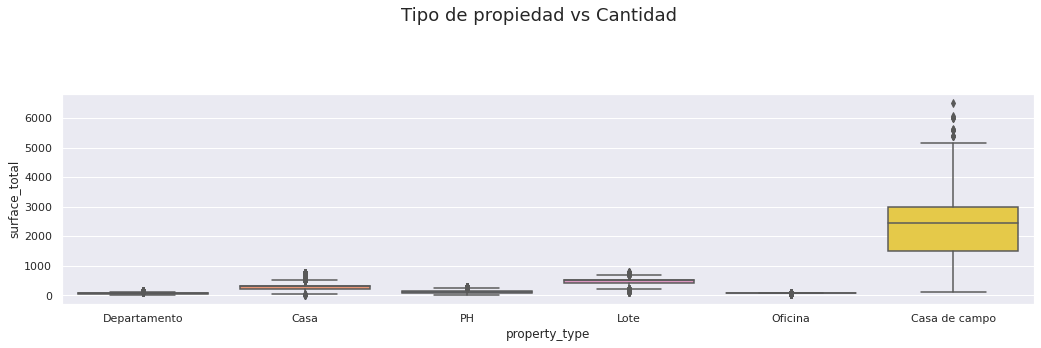

In [216]:
## creamos la figura con subplots de 1 linea 2 columnas
fig, axes = plt.subplots(1, figsize=(15, 5))
fig.suptitle('Tipo de propiedad vs Cantidad', fontsize=18)
#padding between subplots. Pass a float parameter to specify the amount of padding between subplots.
fig.tight_layout(pad=3.0)
sns.boxplot(data = concatDF, x = 'property_type', y = "surface_total", order = concatDF['property_type'].value_counts().index, palette="Set2")
plt.show()

In [217]:
#concatDF6.property_type.unique()
lista_boxplot_sincasacampo = ['Oficina',
        'Departamento', 'PH', 'Casa','Lote']
df_boxplot = concatDF[(concatDF.property_type.isin(lista_boxplot_sincasacampo) ) ]
#df_boxplot.property_type.unique()

Quitamos Casa de Campo para poder visualizar mejor en el bloxplot

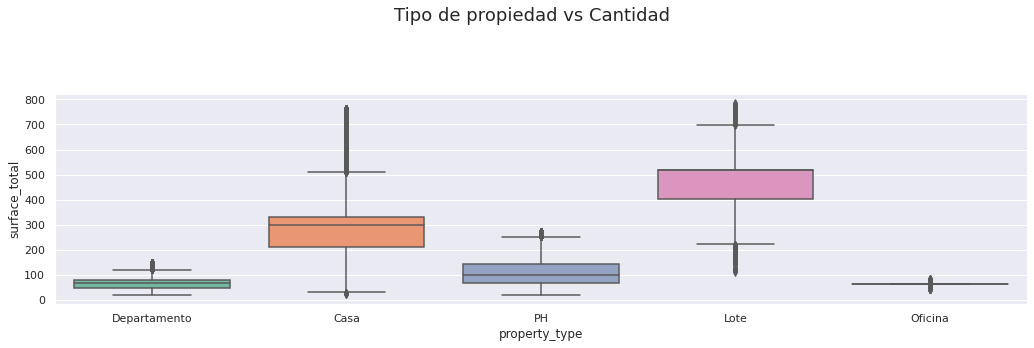

In [218]:
## creamos la figura con subplots de 1 linea 2 columnas
fig, axes = plt.subplots(1, figsize=(15, 5))
fig.suptitle('Tipo de propiedad vs Cantidad', fontsize=18)
#padding between subplots. Pass a float parameter to specify the amount of padding between subplots.
fig.tight_layout(pad=3.0)
sns.boxplot(data = df_boxplot, x = 'property_type', y = "surface_total", order = df_boxplot['property_type'].value_counts().index, palette="Set2")
plt.show()

En este gráfico podemos observar mejor la distribución de los datos según el tipo de propiedad. Vemos que son bastante simétricas todas, los valores mayores y menores no se alejan mucho del valor medio, salvo Casa que tiene una distribución sesgada hacia la izquierda y Los datos se concentran en la parte superior de la distribución. 

#### Realizamos un boxplot para observar la distribución de los precios

In [219]:
df8 = concatDF.copy()
df8.shape

(104005, 14)

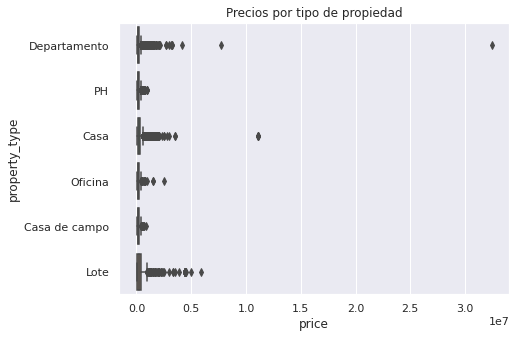

In [220]:
fig, axes = plt.subplots(1, figsize=(7, 5))
plt.title("Precios por tipo de propiedad")
sns.boxplot(data = df8, x = 'price', y = "property_type")
plt.show()

Hay outliers que distorcionan el gráfico, vemos que los datos está situados en valores más pequeños.

In [221]:
df8.describe()

,rooms,surface_total,surface_covered,price
count,104005.000000,104005.000000,104005.000000,1.040050e+05
mean,2.940445,123.036354,86.237109,1.928897e+05
std,1.322854,180.231187,75.036763,2.042566e+05
min,1.000000,21.000000,1.000000,7.500000e+03
25%,2.000000,55.000000,49.000000,1.050000e+05
50%,3.000000,68.000000,60.000000,1.500000e+05
75%,4.000000,120.000000,97.000000,2.341920e+05
max,35.000000,6500.000000,6000.000000,3.243423e+07


Aplicamos la regla del rango intercuartilico para filtrar los datos deacuerdo el precio por cada tipo de propiedad.

In [222]:
## dataframe filtrado Departamento quitando los datos fuera de los límites de 1.5*IQR
df_out_Departamento, limit_Departamento_low, limit_Departamento_high = remove_outlier(df8,'price','Departamento')
print("Límite inferior {} y límite superior {}".format(limit_Departamento_low, limit_Departamento_high))

Límite inferior -80000.0 y límite superior 400000.0


In [223]:
df_out_PH, limit_PH_low, limit_PH_high = remove_outlier(df8,'price','PH')
print("Límite inferior {} y límite superior {}".format(limit_PH_low, limit_PH_high))

Límite inferior -70000.0 y límite superior 378000.0


In [224]:
df_out_Casa, limit_Casa_low, limit_Casa_high = remove_outlier(df8,'price','Casa')
print("Límite inferior {} y límite superior {}".format(limit_Casa_low, limit_Casa_high))

Límite inferior -130500.0 y límite superior 561500.0


In [225]:
df_out_Oficina, limit_Oficina_low, limit_Oficina_high = remove_outlier(df8,'price','Oficina')
print("Límite inferior {} y límite superior {}".format(limit_Oficina_low, limit_Oficina_high))
#ajustamos los límites:
df_in_type = df8[df8.property_type=='Oficina']
df_out_Oficina = df_in_type.loc[(df_in_type['price'] > 7500) & (df_in_type['price'] < limit_Oficina_high)]

Límite inferior -79488.25 y límite superior 383813.75


In [226]:
#df8.property_type.unique()

In [227]:
df_out_CasaCampo, limit_CasaCampo_low, limit_CasaCampo_high = remove_outlier(df8,'price','Casa de campo')
print("Límite inferior {} y límite superior {}".format(limit_CasaCampo_low, limit_CasaCampo_high))
#ajustamos los límites:
df_in_type = df8[df8.property_type=='Casa de campo']
df_out_CasaCampo = df_in_type.loc[(df_in_type['price'] > 7500) & (df_in_type['price'] < limit_CasaCampo_high)]

Límite inferior -50000.0 y límite superior 430000.0


In [228]:
#df_out_Deposito, limit_Deposito_low, limit_Deposito_high = remove_outlier(df8,'price','Depósito')
#print("Límite inferior {} y límite superior {}".format(limit_Deposito_low, limit_Deposito_high))
##ajustamos los límites:
#df_in_type = df8[df8.property_type=='Depósito']
#df_out_Deposito = df_in_type.loc[(df_in_type['price'] > 7500) & (df_in_type['price'] < limit_Deposito_high)]

In [229]:
#df_out_LocalComercial, limit_LocalComercial_low, limit_LocalComercial_high = remove_outlier(df8,'price','Local comercial')
#print("Límite inferior {} y límite superior {}".format(limit_LocalComercial_low, limit_LocalComercial_high))
##ajustamos los límites:
#df_in_type = df8[df8.property_type=='Local comercial']
#df_out_LocalComercial = df_in_type.loc[(df_in_type['price'] > 7500) & (df_in_type['price'] < limit_LocalComercial_high)]

In [230]:
#df_out_Cochera, limit_Cochera_low, limit_Cochera_high = remove_outlier(df8,'price','Cochera')
#print("Límite inferior {} y límite superior {}".format(limit_Cochera_low, limit_Cochera_high))
##ajustamos los límites:
#df_in_type = df8[df8.property_type=='Cochera']
#df_out_Cochera = df_in_type.loc[(df_in_type['price'] > 2000) & (df_in_type['price'] < limit_Cochera_high)]

In [231]:
df_out_Lote, limit_Lote_low, limit_Lote_high = remove_outlier(df8,'price','Lote')
print("Límite inferior {} y límite superior {}".format(limit_Lote_low, limit_Lote_high))
#ajustamos los límites:
df_in_type = df8[df8.property_type=='Lote']
df_out_Lote = df_in_type.loc[(df_in_type['price'] > 2000) & (df_in_type['price'] < limit_Lote_high)]

Límite inferior -457687.5 y límite superior 962612.5


In [232]:
print("df_out_Departamento",df_out_Departamento.shape[0])
print("df_out_PH",df_out_PH.shape[0])
print("df_out_Casa",df_out_Casa.shape[0])
print("df_out_Oficina",df_out_Oficina.shape[0])
print("df_out_CasaCampo",df_out_CasaCampo.shape[0])
#print("df_out_LocalComercial",df_out_LocalComercial.shape[0])
#print("df_out_Cochera",df_out_Cochera.shape[0])
print("df_out_Lote",df_out_Lote.shape[0])

df_out_Departamento 70271
df_out_PH 10028
df_out_Casa 17145
df_out_Oficina 379
df_out_CasaCampo 263
df_out_Lote 958


Analizamos que propiedades descartamos en cada caso, ver si son outliers o valores extremos. Ponemos un límite inferior de 7.5mil dolares tomamos el valor mínimo de los datos estadísticos, ya que el límite mínimo nos da un valor negativo y no hay instancias allí. Esto lo realizamos para PH, Departamentos y Casas

Usamos el dataframe ya filtrado por la función `remove_outlier` y luego volvemos a filtrar por un valor coherente de mínimo de propiedad y vemos lo obtenido.

In [233]:
df_out_Departamento_discard = df_out_Departamento[(df_out_Departamento.price < 7500) | (df_out_Departamento.price > limit_Departamento_high)]
df_out_PH_discard = df_out_PH[(df_out_PH.price < 7500) | (df_out_PH.price > limit_PH_high)]
df_out_Casa_discard = df_out_Casa[(df_out_Casa.price < 7500) | (df_out_Casa.price > limit_Casa_high )]

Concatenamos y volvemos armar el DataSet

In [234]:
concatDF2 = pd.concat([df_out_Departamento,
                      df_out_PH,
                      df_out_Casa,
                      df_out_Oficina,
                      df_out_CasaCampo,
                      df_out_Lote])

In [235]:
concatDF2.shape

(99044, 14)

Gráficamos la distribución de los precios

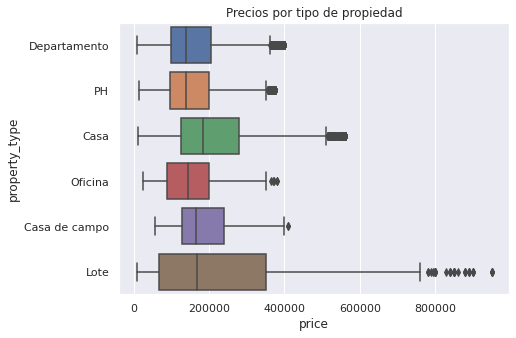

In [236]:
fig, axes = plt.subplots(1, figsize=(7, 5))
plt.title("Precios por tipo de propiedad")
sns.boxplot(data = concatDF2, x = 'price', y = "property_type")
plt.show()

In [237]:
mediana = "mediana" " " + str(int(muestra.median()))
moda= "moda" " " + str(int(muestra.mode()))
media = "media" " " + str(int(muestra.mean()) )

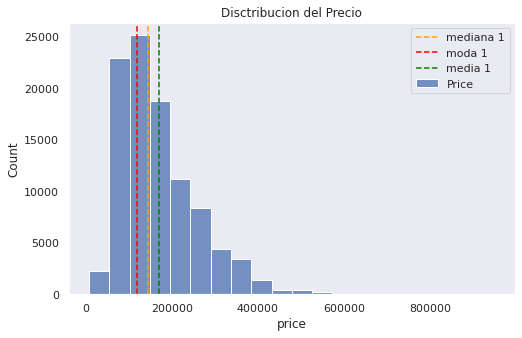

In [238]:
muestra = concatDF2['price']
#plt.hist(muestra, bins = 25, alpha = 0.5, label = 'Price')
fig = plt.subplots(1, figsize=(8, 5))
sns.histplot(muestra, bins = 20, label = 'Price')
#plt.xlim([78000,550000]) ## limite en x, para acotar y quitar los outliers
#plt.ylim([79,101]) ## limite en y, para acotar en eje "y" quitar los outliers
plt.axvline(x=muestra.median(), color='orange' , linestyle='--', label=mediana )
plt.axvline(x=int(muestra.mode()), color='red' , linestyle='--', label=moda )
plt.axvline(x=muestra.mean(), color='green' , linestyle='--', label=media )

plt.title("Disctribucion del Precio")
plt.legend()
plt.grid()
plt.show()

In [239]:
if True:
   concatDF2.to_csv('df9.csv', index= False)

#### **Escalado de Datos**

Vamos a escalar los datos antes de pasarlos al modelo, lo vamos hacer manualmente con Z-score

z = (x - mean) / std

In [240]:
df9 = concatDF2.copy()

In [241]:
columns = ['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']

In [242]:
# Me fijo que tipo de datos son cada columna a las cuales voy a escalar:
df9[columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99044 entries, 351 to 145324
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rooms            99044 non-null  float64
 1   bedrooms         99044 non-null  object 
 2   bathrooms        99044 non-null  object 
 3   surface_total    99044 non-null  float64
 4   surface_covered  99044 non-null  float64
dtypes: float64(3), object(2)
memory usage: 6.5+ MB


In [243]:
#Selecciono las columnsa categoricas 
cat_columns = df9[columns].select_dtypes(['object']).columns
print(cat_columns)

Index(['bedrooms', 'bathrooms'], dtype='object')


In [244]:
#convertir a categorical, busco las columnas a convertir
df9[columns] = df9[columns].astype('float64')

In [245]:
#tipos de variables
#df9.info()

Escalamos los datos con Z-Score

In [246]:
for columna in columns:
    valor_medio = df9[columna].mean()
    std = df9[columna].std()
    df9[columna] =  (df9[columna] - valor_medio) / std

In [247]:
df9.head()

,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,title,description,property_type,dummy_bathrooms,dummy_surface_total,dummy_surface_covered
351,Capital Federal,Congreso,-1.473440,-0.767118,-0.572061,-0.542544,-0.842361,72000.0,VENTA MONOAMBIENTE CONGRESO EXCELENTE ESTADO,Corredor Responsable: Damian Perrone - CUCICBA...,Departamento,1,0,0
438,Capital Federal,Villa Ortuzar,0.878208,1.119771,-0.572061,-0.177613,0.069424,192000.0,DEPTO.3 AMB Y DEP - AV. A. THOMAS 1395-V.ORTUZAR,Corredor Responsable: Ariel Champanier - C.U.C...,Departamento,1,0,0
573,Capital Federal,Caballito,-0.689558,-0.767118,-0.572061,-0.531315,-0.842361,70000.0,DEPARTAMENTO EN VENTA,Xintel (MSD-MSD-50) <p>Departamento 2 AMBIENTE...,Departamento,1,0,0
614,Capital Federal,Villa Pueyrredón,-1.473440,-1.710562,-0.572061,-0.458329,-0.716114,85000.0,DEPARTAMENTO EN VENTA,Xintel (CBP-CBP-79) Venta de Departamento MONO...,Departamento,1,0,0
655,Capital Federal,Almagro,-0.689558,-0.767118,-0.572061,-0.441486,-0.589867,85000.0,DEPARTAMENTO EN VENTA,Xintel (NVS-NVS-133) Venta de Departamento DOS...,Departamento,1,0,0


In [248]:
if True:
    df9.to_csv('df9.csv', index= False)

#### **Encoding**

Convertimos las variables categóricas en númericas para que puedan ser tomadas por el modelo. Usamos get_dummies de pandas para crear nuevas features para las variables categóricas nominales. no usamos map() ni LabelEncoder para no asignarles pesos a cada variable, sino que las consideramos todos por igual ya que no son ordinales.

Tipos de enconding considerados y/o aplicados:

- Label Encoding: codifica las etiquetas con un valor entre 0 y n_classes -1
- One-Hot-Encoding: crea una variable dummy por cada posible valor de la variable categórica
- Frecuency Encodign: utiliza la frecuencia de las categorias como etiquetas
- Target or Impact or Likelihood Encoding: En este caso las etiquetas se correlacionan directamente con la variable target, por ejemplo, asignando el valor medio de la variable target en los datos de entrenamiento ue toma en cada categoría.

In [249]:
df10 = pd.read_csv('df9.csv')
df10.drop(['title','description'],axis=1, inplace=True)

In [250]:
#df10 = df9.copy()
#df10.shape

In [251]:
df10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99044 entries, 0 to 99043
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   l2                     99044 non-null  object 
 1   l3                     99044 non-null  object 
 2   rooms                  99044 non-null  float64
 3   bedrooms               99044 non-null  float64
 4   bathrooms              99044 non-null  float64
 5   surface_total          99044 non-null  float64
 6   surface_covered        99044 non-null  float64
 7   price                  99044 non-null  float64
 8   property_type          99044 non-null  object 
 9   dummy_bathrooms        99044 non-null  int64  
 10  dummy_surface_total    99044 non-null  int64  
 11  dummy_surface_covered  99044 non-null  int64  
dtypes: float64(6), int64(3), object(3)
memory usage: 9.1+ MB


In [252]:
#Observo cuales son las columnas categóricas
cat_columns = df10.select_dtypes(['object']).columns
print(cat_columns)

Index(['l2', 'l3', 'property_type'], dtype='object')


Se aplicará encoding para las variables l2, l3 y property_type

**l2: Región**

Aplicamos frecuency encoding para l2, se descarta la opción de Label Encoding ya que no presenta una realación de orden entre sus etiquetas. Se realiza One-Hot_encoding ya que sólo contamos con 4 tipos de regiones y no realizará un incremento considerable en la dimenisón de nuesto dataset. También se probará Frecuency Encoding.

In [253]:
# One Hot Encoding
dum_l2 = pd.get_dummies(df10['l2'],drop_first=True)
df10 = pd.concat([df10,dum_l2], axis=1)
df10.head(2)

,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type,dummy_bathrooms,dummy_surface_total,dummy_surface_covered,Bs.As. G.B.A. Zona Oeste,Bs.As. G.B.A. Zona Sur,Capital Federal
0,Capital Federal,Congreso,-1.473440,-0.767118,-0.572061,-0.542544,-0.842361,72000.0,Departamento,1,0,0,0,0,1
1,Capital Federal,Villa Ortuzar,0.878208,1.119771,-0.572061,-0.177613,0.069424,192000.0,Departamento,1,0,0,0,0,1


In [254]:
# Frequency Encoding
l2_frec = df10.copy()
l2_frec['contador'] = 1
l2_frec = l2_frec.groupby(['l2'], as_index=False)['contador'].sum().rename(columns= {'contador': 'l2_frec'}, inplace=False)
l2_frec.head(10)

,l2,l2_frec
0,Bs.As. G.B.A. Zona Norte,16718
1,Bs.As. G.B.A. Zona Oeste,11252
2,Bs.As. G.B.A. Zona Sur,14297
3,Capital Federal,56777


**l3: Barrio**

Para esta variable se descartarńa las opciones de Label Encoding ya que no presenta una realación de orden entre sus etiquetas y One-Hot-Encoding debido a que la cantidad de valores posibles que puede tomar la variable incrementaría exponencialmente el tamaño de nuestro dataset.

Aplicaremos los siguientes Encoding para esta variable:

- Frequency Encoding: Teniendo en cuenta que no tenemos una cantidad de muestras homogeneas por barrio, este tipo de encodeado puede que el algoritmo entienda una poderación que tiene cada observación.
- Target Encoding: Por conocimiento del negocio, los inmuebles son tasados principalmente por su ubicación más que por sus características con lo cual podemos encodearlas por la mediana de su precio. 


In [255]:
# Cantidad de valores posibles de l3
df10['l3'].unique().size

89

In [256]:
# Frecuency Encoding
l3_frec = df10.copy()
l3_frec['contador'] = 1
l3_frec = l3_frec.groupby(['l3'], as_index=False)['contador'].sum().rename(columns= {'contador':'l3_frec'}, inplace = False)
l3_frec.head()

,l3,l3_frec
0,Abasto,236
1,Agronomía,127
2,Almagro,3212
3,Almirante Brown,1026
4,Avellaneda,1167


In [257]:
# Agrego la variable l3_frec al dataset
df10 = df10.merge(l3_frec, how='left', on=['l3'])

In [258]:
df10.head(2)

,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type,dummy_bathrooms,dummy_surface_total,dummy_surface_covered,Bs.As. G.B.A. Zona Oeste,Bs.As. G.B.A. Zona Sur,Capital Federal,l3_frec
0,Capital Federal,Congreso,-1.473440,-0.767118,-0.572061,-0.542544,-0.842361,72000.0,Departamento,1,0,0,0,0,1,427
1,Capital Federal,Villa Ortuzar,0.878208,1.119771,-0.572061,-0.177613,0.069424,192000.0,Departamento,1,0,0,0,0,1,272


In [259]:
# Target Encoding
df10['l3'] = df10['l3'].map(df10.groupby('l3')['price'].mean())

In [260]:
df10.head(2)

,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type,dummy_bathrooms,dummy_surface_total,dummy_surface_covered,Bs.As. G.B.A. Zona Oeste,Bs.As. G.B.A. Zona Sur,Capital Federal,l3_frec
0,Capital Federal,127219.372365,-1.473440,-0.767118,-0.572061,-0.542544,-0.842361,72000.0,Departamento,1,0,0,0,0,1,427
1,Capital Federal,191978.952206,0.878208,1.119771,-0.572061,-0.177613,0.069424,192000.0,Departamento,1,0,0,0,0,1,272


##### **property_type: Tipo de propiedad**
Para esta variable se probarán One-Hot_Encoding ya son pocas los tipos de propiedades. 

In [261]:
# One-Hot-Encoding
dum_pt = pd.get_dummies(df10['property_type'], drop_first=True)
df10 = pd.concat([df10,dum_pt], axis=1)

In [262]:
df10.head(2)

,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type,dummy_bathrooms,...,dummy_surface_covered,Bs.As. G.B.A. Zona Oeste,Bs.As. G.B.A. Zona Sur,Capital Federal,l3_frec,Casa de campo,Departamento,Lote,Oficina,PH
0,Capital Federal,127219.372365,-1.473440,-0.767118,-0.572061,-0.542544,-0.842361,72000.0,Departamento,1,...,0,0,0,1,427,0,1,0,0,0
1,Capital Federal,191978.952206,0.878208,1.119771,-0.572061,-0.177613,0.069424,192000.0,Departamento,1,...,0,0,0,1,272,0,1,0,0,0


Escalamos las variables incorporadas

In [263]:
columns = ['l3', 'l3_frec']

In [264]:
for columna in columns:
    valor_medio = df10[columna].mean()
    std = df10[columna].std()
    df10[columna] =  (df10[columna] - valor_medio) / std

In [265]:
df10.head(2)

,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type,dummy_bathrooms,...,dummy_surface_covered,Bs.As. G.B.A. Zona Oeste,Bs.As. G.B.A. Zona Sur,Capital Federal,l3_frec,Casa de campo,Departamento,Lote,Oficina,PH
0,Capital Federal,-1.200704,-1.473440,-0.767118,-0.572061,-0.542544,-0.842361,72000.0,Departamento,1,...,0,0,0,1,-1.234255,0,1,0,0,0
1,Capital Federal,0.660788,0.878208,1.119771,-0.572061,-0.177613,0.069424,192000.0,Departamento,1,...,0,0,0,1,-1.327281,0,1,0,0,0


#### Elegimos las features que se le pasaran al modelo

In [266]:
#hacemos una copia del dataset
df11 = df10.copy()

In [267]:
#sns.heatmap(df11.corr(), cbar = True,  square = True, annot=True, fmt= '.2f',cmap= 'coolwarm')

hacemos un drop de las columnas que no vamos a emplear en el modelo

In [268]:
lista_drop = ['l2','dummy_bathrooms', 'dummy_surface_total','dummy_surface_covered','property_type']

In [269]:
df11.drop(lista_drop, axis=1, inplace=True)

In [270]:
df11.head(2)

,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,Bs.As. G.B.A. Zona Oeste,Bs.As. G.B.A. Zona Sur,Capital Federal,l3_frec,Casa de campo,Departamento,Lote,Oficina,PH
0,-1.200704,-1.473440,-0.767118,-0.572061,-0.542544,-0.842361,72000.0,0,0,1,-1.234255,0,1,0,0,0
1,0.660788,0.878208,1.119771,-0.572061,-0.177613,0.069424,192000.0,0,0,1,-1.327281,0,1,0,0,0


In [271]:
if True:
    df11.to_csv('df11.csv', index= False)

df10 = pd.read_csv('df9.csv')
#### Reduccion de la dimensionalidad (PSA)

In [272]:
df11 = pd.read_csv('df11.csv')
df11.head(2)

,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,Bs.As. G.B.A. Zona Oeste,Bs.As. G.B.A. Zona Sur,Capital Federal,l3_frec,Casa de campo,Departamento,Lote,Oficina,PH
0,-1.200704,-1.473440,-0.767118,-0.572061,-0.542544,-0.842361,72000.0,0,0,1,-1.234255,0,1,0,0,0
1,0.660788,0.878208,1.119771,-0.572061,-0.177613,0.069424,192000.0,0,0,1,-1.327281,0,1,0,0,0


In [546]:
# Elegimos la data para predecir y el target y
X = df11.drop(['price'],axis=1)
y = df11['price']

In [547]:
from sklearn.decomposition import PCA
x_components = X.shape[1] 
pca = PCA(n_components=x_components)
X_pca = pca.fit_transform(X) 

In [548]:
#pca.components_
#Valores más grandes de la matriz de covarianza de X
#pca.explained_variance_
#pca.explained_variance_ratio_

In [549]:
# Determine explained variance using explained_variance_ration_ attribute
exp_var_pca = pca.explained_variance_ratio_

In [550]:
#Suma acumulativa de los engeinvalores; Esto se utilizará para crear un diagrama de pasos.
#para visualizar la varianza explicada por cada componente principal.
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

Visualización de la varianza explicada y los pasos acumulativos

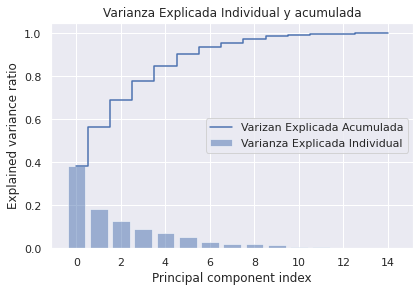

In [551]:
# Visualización
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Varianza Explicada Individual')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Varizan Explicada Acumulada')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.title("Varianza Explicada Individual y acumulada")
plt.show()

Se observa que con los 7 primeros componentes ya tenemos un 93% de la varianza explicada. Es decir que si dejamos las primeras 7 features, logramos que nuestros datos puedan explicar el 93% de la varianza.

In [552]:
exp_var_pca[0:7].sum()

0.9362811976515406

Conlcusión: que con 7 atributos de mi nueva matriz de correlacion ya puedo explicar el 93% de mi varianza. Con lo cual ahora puedo usar PCA para reducir la dimencionalidad de mi dataset

In [553]:
# selecciono componentes=10  ya que explican el 90% de la varianza, reduciendo el dataset de 66 a 10 atributos
pca = PCA(n_components=7)
X_pca = pca.fit_transform(X) 

In [554]:
# lo convierto a Dataframe para poder realizar un heatmap
X_pca = pd.DataFrame(X_pca)

# **Machine Learning**

**Modelos sencillos**:

- LinearRegression
- LinearRegression con PCA

**Modelos avanzados**:

- DecisionTreeRegresor
- DecisionTreeRegresor con PCA
- DecisionTreeRegresor con PolynomialFeatures
- DecisionTreeRegresor con Optimización de Hiperparametros (Random Search y CV)
- DecisionTreeRegresor con Optimización de Hiperparametros (RandomForestRegressor)
- DecisionTreeRegresor con Optimización de Hiperparametros (Regularización para disminuir el overfitting)
- SGDRegressor
- SGDRegressor con PCA


Se crea una función para evaluar todos los modelos, es decir calcular el RMSE sobre train y test.

In [555]:
# Creamos una funciona para evaluar nuestros modelos
def evaluar_regresion_gon(model, X_train, X_test, y_train, y_test):
    '''
    Esta función es para evaluar los modelos de regresion, obteniendo el RMSE
    para los conjuntos de datos de test y train.
    También nos muestra el RMSE aplicando cross validation
    
    Argumentos:
    
    * modelo
    * Datos de X_train
    * Datos X_test
    * Datos y_train
    * Datos y_test
    '''
    #predecimos sobre ambos conjuntos de datos
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    ### CALCULAMOS EL ERROR
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

    print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
    print(f'Raíz del error cuadrático medio en Test: {rmse_test}')
    print("Scores cross validation")
    scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
    print(list(np.sqrt(scores*(-1))))
    rmse_cv = round(np.mean(np.sqrt(-scores)))
    ### GRAFICAMOS LOS RESULTADOS
    plt.figure(figsize = (12,4))
    
    #print(X_test.shape)
    #print(y_test_pred.shape)
    print()
 
    plt.subplot(1,2,1)
    sns.histplot(y_train - y_train_pred, bins = 50, label = 'train',color='#ff7f0e')
    sns.histplot(y_test - y_test_pred, bins = 50, label = 'test')
    plt.xlabel('errores')
    plt.title("Distribución del error")
    plt.legend()

    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,y_test_pred, s =2)

    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]

    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')
    plt.tight_layout()
    plt.title("RMSE")
    plt.show()
    
    return rmse_train,rmse_test,rmse_cv

### **Modelos Sencillos**

### LinearRegression

In [561]:
# Dividimos los datos en Train y Test
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [562]:
from sklearn.linear_model import LinearRegression

In [563]:
#creamos el objetos 
linear_model = LinearRegression()

#entrenamos el modelo
linear_model.fit(X_train, y_train)

#La regresión lineal obtiene la pendiente y la ordenada al origen.
#print(linear_model.coef_, linear_model.intercept_)

LinearRegression()

Raíz del error cuadrático medio en Train: 61017.61596840879
Raíz del error cuadrático medio en Test: 60486.56085421479
Scores cross validation
[60040.58029570182, 61222.754624424204, 63643.065450830276, 61892.79866690591, 60627.02490668815]



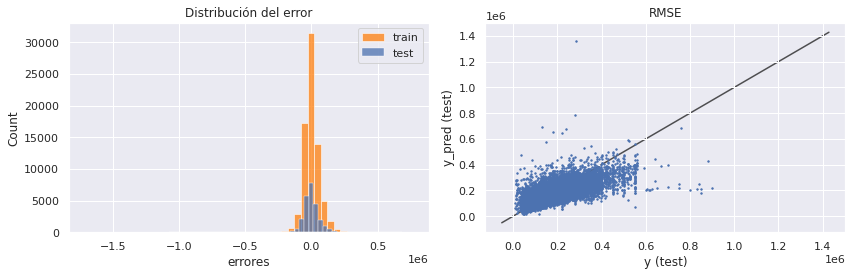

In [564]:
rmse_train_linear_model,rmse_test_linear_model,rmse_cv_linear_model = evaluar_regresion_gon(linear_model,X_train, X_test, y_train, y_test)

El histograma de los errores de ambos conjuntos son simétricos, aproximadamente gaussianos y concentrado cerca de 0. Esto quiere decir que el error de la predicción está concentrado alrededor del cero de manera casi simetrica, es decir que tendremos propiedades sobrevaluadas como devaluadas girando al valor del RMSE obtenido.

El gráfico de RMSE, se observa que el modelo es más preciso para valores de propiedades cuyo precio son menores a 350000, luego desde allí comienza a aumentar el error, teniendo propiedades con valores devaluados (el predecido menor al real del target). Ya a partir de 500000 el residuo de los valores se incrementa y así el error en las predicciones. 

Importancia de las variables:

Feature: 0, Score: 28698.64048
Feature: 1, Score: 24134.32975
Feature: 2, Score: 2874.60810
Feature: 3, Score: 25943.29231
Feature: 4, Score: 4477.33250
Feature: 5, Score: 22278.46733
Feature: 6, Score: -4301.01492
Feature: 7, Score: -8949.42790
Feature: 8, Score: 24264.78137
Feature: 9, Score: 5184.28151
Feature: 10, Score: -92638.01473
Feature: 11, Score: 11521.75271
Feature: 12, Score: 10222.65066
Feature: 13, Score: 35382.90399
Feature: 14, Score: -6208.76951


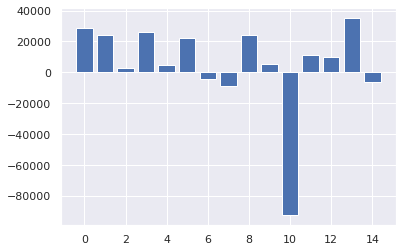

In [565]:
from matplotlib import pyplot

# get importance
importance = linear_model.coef_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

Esto nos indica que podríamos las features que tienen score negativo ya no no aportan para el modelo estudiado. Pudiendo resucirlo a las features 0,1,2,3,5,8,13 y 18.

### LinearRegression con PCA

Raíz del error cuadrático medio en Train: 61676.93796834152
Raíz del error cuadrático medio en Test: 61154.87812197201
Scores cross validation
[60527.03230518351, 61471.90956692841, 63702.12213846747, 62769.38061180285, 61000.866759996024]



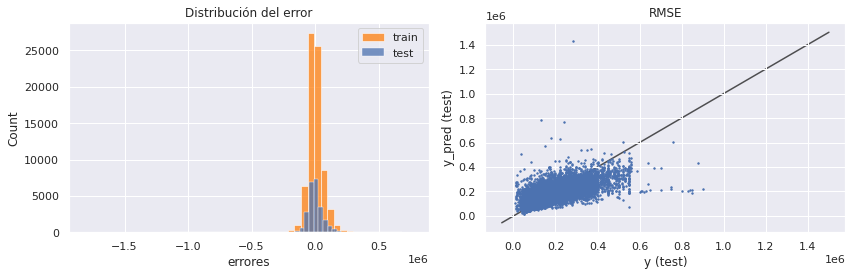

In [566]:
# Dividimos los datos en Train y Test
from sklearn.model_selection import train_test_split

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, random_state=42)

#creamos el objetos 
linear_model = LinearRegression()

#entrenamos el modelo
linear_model.fit(X_train_pca, y_train_pca)

rmse_train_linear_model_pca,rmse_test_linear_model_pca,rmse_cv_linear_model_pca = evaluar_regresion_gon(linear_model,X_train_pca, X_test_pca, y_train_pca, y_test_pca)

La distribución del error y el RMSE no cambia con respecto al modelo anterior.

Importancia de cada Feature:

Feature: 0, Score: 27232.46710
Feature: 1, Score: -34091.85417
Feature: 2, Score: 2434.41669
Feature: 3, Score: 22606.53684
Feature: 4, Score: 4499.15293
Feature: 5, Score: 14596.37911
Feature: 6, Score: 18962.41088


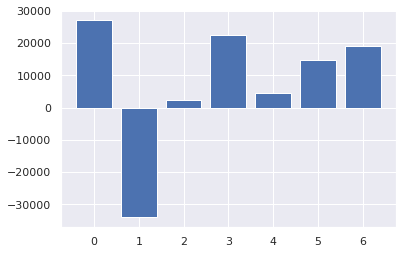

In [567]:
from matplotlib import pyplot

# get importance
importance = linear_model.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

**Conslusión** 
Los errores RMSE representan el error global del regresor. Son similares tanto para test como para train, indicando que no hay un gran sobreajuste para valores pequeños de y. Los histogramas de los errores son simétricos, aproximadamente gaussianos, y parecidos para ambos conjuntos y concentrados cerca de 0.

Comparado con el primer modelo, el que teniamos como baseline se ha producido una mejora considerable, pasamos de un RMSE de test de 202449 a 61154. Por una parte se debe a que se analizaron más minuciosamente los datos faltantes antes de descartarlos, con lo cual se usó imputación, se agregaron nuevas features y principalemnte se escalaron los datos usando z-score (solamente a los datos que no eran bianrios), lo cual es muy importante al usar en un modelo de regresión líneal

Aplicando PCA aumenta un poco el error (1%) pero bajammos de 15 features a 7. En ambos casos aparentan ser modelos estables. Egún el gráfico de aariba para este modelo podriamos descartar las variables 1,2 y 4.

### **Modelos Avanzados**

Como se trata de un problema con variable continua, es decir que lo que intentamos predecir es una variable numerica continua vamos a usar modelos de regresión que son los que mejores se adaptan a este tipo de datos. <br>
Anteriormente elegimos un modelo sencillo de regresión para comparar con el sprint 1, ahora elegimos `DecisionTreeRegressor` y `SGDRegressor`, dos modelos que se adaptan bien a este tipo de datos. Para el primero vamos a probar con PolinomialFeature, PCA y sin modificar los datos de entrada.También se probará regularización con L2 (Ridge) porque hay variables de entrada correlacionadas, así disminuir el overfitting y nuestro modelo generalice bien.

### Modelo  DecisionTreeRegresor

In [290]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [291]:
from random import randint

# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

In [292]:
#from sklearn.cross_validation import cross_val_score 
from sklearn.tree import DecisionTreeRegressor

In [293]:
#creamos el modelo
tree_regressor = DecisionTreeRegressor(random_state=0)

In [294]:
#entrenamos
tree_regressor.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

In [295]:
#R^2 score
#print(tree_regressor.score(X_test,y_test))

Importancia de cada Feature:

Feature: 0, Score: 0.16059
Feature: 1, Score: 0.03496
Feature: 2, Score: 0.02356
Feature: 3, Score: 0.35803
Feature: 4, Score: 0.11778
Feature: 5, Score: 0.20220
Feature: 6, Score: 0.00222
Feature: 7, Score: 0.00507
Feature: 8, Score: 0.03609
Feature: 9, Score: 0.03980
Feature: 10, Score: 0.00011
Feature: 11, Score: 0.00702
Feature: 12, Score: 0.00495
Feature: 13, Score: 0.00052
Feature: 14, Score: 0.00710


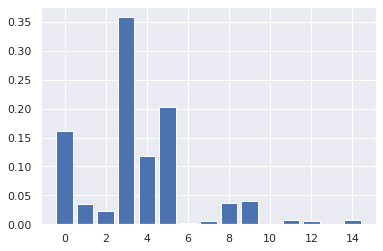

In [296]:
# get importance
importance = tree_regressor.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

Las features 0,3,4 y 5, son las más importantes para este modelo. Con lo cual se podría eliminar el resto para simplificar el modelo a 4 features.

Raíz del error cuadrático medio en Train: 26178.158584624252
Raíz del error cuadrático medio en Test: 54772.339990588625
Scores cross validation
[55968.62145661098, 58194.64605930842, 56074.585326610206, 57840.28743381131, 56054.93043047497]



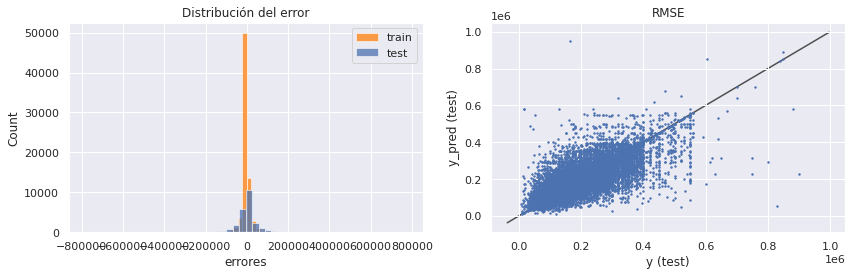

In [297]:
rmse_train_TreeRegresor,rmse_test_TreeRegresor,rmse_cv_TreeRegresor = evaluar_regresion_gon(tree_regressor,X_train, X_test, y_train, y_test)

El histograma del error de train se observa cierta asimetría, sesgada hacia la izquierda. Esto quiere decir que para el conjunto de train se observa que más de 50000 predicciones (y_test_pred) que tuvieron una predicción mayor al número que teniamos como target (y_test), con lo cual habrá más propiedades sobrevaluadas, no así sobre el conjunto de test que tiene un distribución más cercana a normal.

El gráfico de RMSE, se observa que el modelo es más preciso para valores de propiedades menores a 400000 luego desde allí comienza a aumentar el error, teniendo propiedades con valores devaluados (el predecido menor al real del target). Ya a partir de 500000 el residuo de los valores se incrementa y así el error en las predicciones. 


**Conclusión**: la predicción mejora con respecto a la regresión líneal pero se obtiene un modelo con overfitting, se podría mejorar jugando con los hiperparametros y/o tratando de hacer un modelo más sencillo.

### Modelo  DecisionTreeRegresor con PCA

In [298]:
from random import randint

# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [3, None],
#              "max_features": randint(1, 9),
              "max_features": [1,3,5,8,10],
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

In [299]:
#creamos el modelo
tree_regressor = DecisionTreeRegressor(random_state=0)

In [300]:
#entrenamos
tree_regressor.fit(X_train_pca, y_train_pca)

DecisionTreeRegressor(random_state=0)

In [301]:
#R^2 score
#print(tree_regressor.score(X_test,y_test))

Gráficamo la importancia de las Features:

Feature: 0, Score: 0.37025
Feature: 1, Score: 0.22771
Feature: 2, Score: 0.07378
Feature: 3, Score: 0.07951
Feature: 4, Score: 0.07795
Feature: 5, Score: 0.07444
Feature: 6, Score: 0.09635


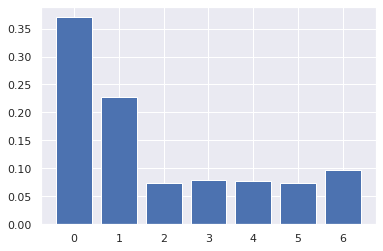

In [302]:
# get importance
importance = tree_regressor.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

Las features más importantes para este módelo son la 0, 2 y 6

Raíz del error cuadrático medio en Train: 26178.158584624252
Raíz del error cuadrático medio en Test: 56450.95735733423
Scores cross validation
[57275.19600616657, 58467.94068096883, 58184.575288815875, 59652.373237486194, 58024.94520439658]



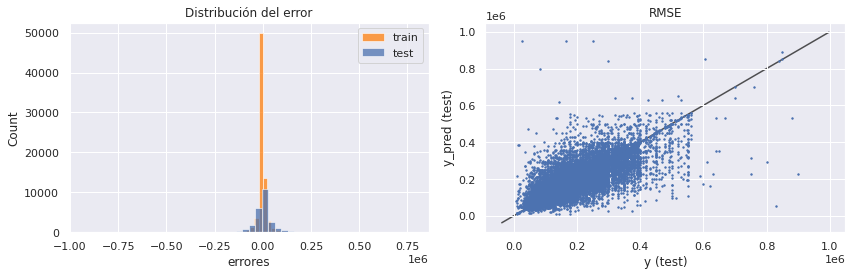

In [303]:
rmse_train_TreeRegresor_pca,rmse_test_TreeRegresor_pca,rmse_cv_TreeRegresor_pca = evaluar_regresion_gon(tree_regressor,X_train_pca, X_test_pca, y_train_pca, y_test_pca)

**Conclusión**: 

Sobre la distribución del error y el RMSE se sacan las mismas conclusiónes que para el Modelo DecisionTreeRegresor (modelo anterior).

Se observa que hay mucha varianza, obtuvimos un modelo muy overfiteado. Similar al anterior pero este es menos complejo desde el punto de vista de computo. Se podría probar solamente dejando las features 0,2 y 6. A continuación vamos a probar el mismo modelo pero con PolinomilaFeatures

### DecisionTreeRegresor con PCA + PolynomialFeatures

#### **Atributos Polinomicos: `PolynomialFeatures`** 

In [304]:
# Importo la clase `PolynomialFeatures`.
from sklearn.preprocessing import PolynomialFeatures

Empleamos PolynomialFeatures y lo aplicamos sobre X_train e X_test. 

In [305]:
poly = PolynomialFeatures(degree=3)
X_train_new = poly.fit_transform(X_train_pca)
X_test_new = poly.transform(X_test_pca)
print(X_train_new.shape,X_test_new.shape)

(74283, 120) (24761, 120)


Se observa como se aumenta la dimensionalidad de nuestro dataset de 10 a 286 features.

In [306]:
#entrenamos
tree_regressor.fit(X_train_new, y_train)

DecisionTreeRegressor(random_state=0)

In [307]:
#R^2 score
print(tree_regressor.score(X_test_new,y_test))

0.5989740323540054


feature importances

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.25992
Feature: 2, Score: 0.00427
Feature: 3, Score: 0.00092
Feature: 4, Score: 0.00276
Feature: 5, Score: 0.00218
Feature: 6, Score: 0.00264
Feature: 7, Score: 0.00282
Feature: 8, Score: 0.00486
Feature: 9, Score: 0.10967
Feature: 10, Score: 0.00316
Feature: 11, Score: 0.00312
Feature: 12, Score: 0.00639
Feature: 13, Score: 0.00504
Feature: 14, Score: 0.00294
Feature: 15, Score: 0.00150
Feature: 16, Score: 0.00386
Feature: 17, Score: 0.00395
Feature: 18, Score: 0.00221
Feature: 19, Score: 0.00318
Feature: 20, Score: 0.00676
Feature: 21, Score: 0.00126
Feature: 22, Score: 0.00315
Feature: 23, Score: 0.00325
Feature: 24, Score: 0.00245
Feature: 25, Score: 0.00298
Feature: 26, Score: 0.00168
Feature: 27, Score: 0.00504
Feature: 28, Score: 0.00192
Feature: 29, Score: 0.00772
Feature: 30, Score: 0.00539
Feature: 31, Score: 0.00221
Feature: 32, Score: 0.00582
Feature: 33, Score: 0.00218
Feature: 34, Score: 0.00708
Feature: 35, Score: 0.00219
Fe

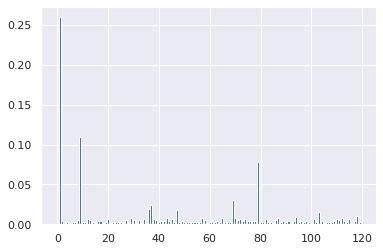

In [308]:
# get importance
importance = tree_regressor.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

Raíz del error cuadrático medio en Train: 26178.158584624252
Raíz del error cuadrático medio en Test: 57698.028579774975
Scores cross validation
[59042.291172592224, 59624.34895733717, 56716.444977886495, 59816.231147021776, 58080.16953674304]



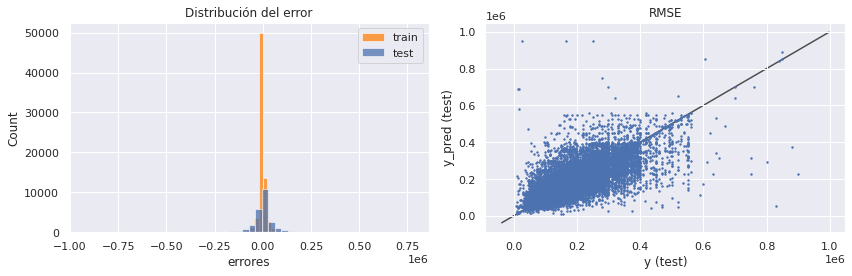

In [309]:
rmse_train_TreeRegresor_pol,rmse_test_TreeRegresor_pol,rmse_cv_TreeRegresor_pol = evaluar_regresion_gon(tree_regressor,X_train_new, X_test_new, y_train, y_test)

**Conclusión**:

Sobre la distribución del error y el RMSE se sacan las mismas conclusiónes que para el Modelo DecisionTreeRegresor.

Nuevamente obtenemos un modelo Overfiteado, con mucha varianza y comparado con el anterior, polinomialFeatures no mejoró el rendimiento, solo aumentó mucho la dimensión (de 7 a 120 features) complicando el computo sin producir mejoras.

### DecisionTreeRegresor con Optimización de Hiperparametros (Random Search y CV)

Se crea una grilla con un generador aleatorio para cada atributo, en aquellos atributos que queremos que explore aleatoriamente y en el resto definimos rangos de valores o valores en si.

In [310]:
from scipy.stats import randint

In [311]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [3, 5, 8, 10, None],
#              "max_features": randint(1, 10),
              "max_features": [1,3,4,5,6,7],
#              "min_samples_leaf": randint(1, 10),
              "min_samples_leaf": [1,3,5,8,10],
              "criterion": ["mse"]}
#              "criterion": ["entropy"]}

In [312]:
#creamos el modelo
tree_regressor = DecisionTreeRegressor(random_state=0)

In [313]:
# Instanciamos el objeto RandomizedSearchCV: tree_cv
tree_cv = RandomizedSearchCV(DecisionTreeRegressor(), param_dist, cv=4,scoring="neg_root_mean_squared_error", n_iter=3)

In [314]:
tree_cv.fit(X_train_pca, y_train_pca)

RandomizedSearchCV(cv=4, estimator=DecisionTreeRegressor(), n_iter=3,
                   param_distributions={'criterion': ['mse'],
                                        'max_depth': [3, 5, 8, 10, None],
                                        'max_features': [1, 3, 4, 5, 6, 7],
                                        'min_samples_leaf': [1, 3, 5, 8, 10]},
                   scoring='neg_root_mean_squared_error')

In [315]:
#best_tree_model = tree_cv.best_estimator_
#best_tree_model

In [316]:
# Print the tuned parameters and score
#print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_estimator_))
print("Best score is {}".format(tree_cv.score(X_test_pca,y_test_pca)))

Best score is -53120.86344158436


Raíz del error cuadrático medio en Train: 42329.30795877764
Raíz del error cuadrático medio en Test: 53120.86344158436
Scores cross validation
[54217.942445958965, 56294.05838203119, 53083.16689410461, 58214.36215164103, 54573.19655069605]



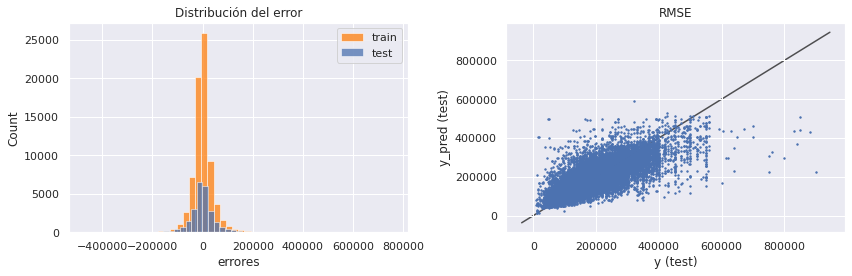

In [317]:
rmse_train_TreeRegresor_pca_rsearch,rmse_test_TreeRegresor_pca_rsearch,rmse_cv_TreeRegresor_pca_rsearch = evaluar_regresion_gon(tree_cv,X_train_pca, X_test_pca, y_train_pca, y_test_pca)

**Conclusión:** La ditribución del error es gausiana para ambos conjuntos (test y train), centradas en 0. El RMSE se observa que el error aumenta para propiedades mayores a los 400000 dolares.

Se mejora el modelo, ya no hay mucha diferencia entre el error de test y train pero sigue teniendo mucha varianza, sobre todo cuando se lo prueba con cross validation. 

### DecisionTreeRegresor con Optimización de Hiperparametros (RandomForestRegressor) + PCA

Tuneado de Hiperparametros con RandomForestRegressor usando random search y cross validation

Ahora definiremos la búsqueda aleatoria pasando el modelo rfr con los hiperparámetros elegidos aleatoriamente y luego lo entrenaremos. Después de esto, comprobaremos la puntuación.

In [318]:
import numpy as np

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 3, stop = 10, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(3, 9, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10,50,1000]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,100,1000]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [3, 4, 6, 8, 10], 'max_features': ['auto', 'sqrt'], 'max_depth': [3, 4, 6, 7, 9, None], 'min_samples_split': [2, 5, 10, 50, 1000], 'min_samples_leaf': [1, 2, 4, 100, 1000], 'bootstrap': [True, False]}


In [319]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(random_state = 1)

In [320]:
rfr_random = RandomizedSearchCV(estimator=rfr, param_distributions=random_grid, n_iter = 20, scoring='neg_root_mean_squared_error', cv = 3, verbose=2, random_state=42, n_jobs=-1, return_train_score=True)

Ahora obtenidos los parametros entrenamos el modelo

In [321]:
rfr_random.fit(X_train_pca, y_train_pca)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=1),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [3, 4, 6, 7, 9, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4, 100,
                                                             1000],
                                        'min_samples_split': [2, 5, 10, 50,
                                                              1000],
                                        'n_estimators': [3, 4, 6, 8, 10]},
                   random_state=42, return_train_score=True,
                   scoring='neg_root_mean_squared_error', verbose=2)

In [322]:
#Hyperparameter Tuning
print(rfr_random.best_params_)

{'n_estimators': 10, 'min_samples_split': 50, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}


In [323]:
print(rfr_random.score(X_test_pca , y_test_pca))

-48272.584902899216


Feature: 0, Score: 0.30719
Feature: 1, Score: 0.22492
Feature: 2, Score: 0.07702
Feature: 3, Score: 0.07695
Feature: 4, Score: 0.14113
Feature: 5, Score: 0.09446
Feature: 6, Score: 0.07833


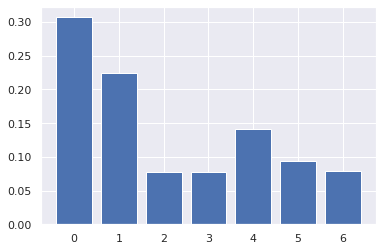

In [568]:
# get importance
importance = rfr_random.best_estimator_.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

Para este modelo las features más relevantes son la 0,1 y 4

Raíz del error cuadrático medio en Train: 40994.555542481416
Raíz del error cuadrático medio en Test: 48272.584902899216
Scores cross validation
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[49302.33652293181, 50217.373350599, 49065.08442352482, 50739.354042615254, 49490.907763761534]



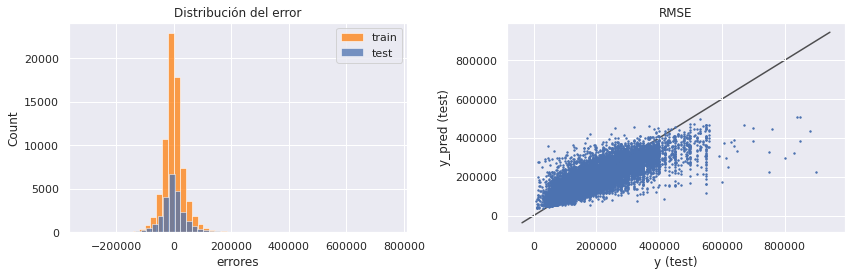

In [325]:
rmse_train_TreeRegresor_pca_rforest,rmse_test_TreeRegresor_pca_rforest,rmse_cv_TreeRegresor_pca_rforest = evaluar_regresion_gon(rfr_random,X_train_pca, X_test_pca, y_train_pca, y_test_pca)

**Conslusión:**

La distribución del error es gausiana ,simétrica para ambos conjuntos, y centrada en 0. El RMSE se observa que el error aumenta para propiedades mayores a los 400000 dolares.
Se obtiene un modelo con mucha varianza, el mismo no generaliza bien, se podría probar con las features que más aportan al módelo para simplificarlo.

### Optimización de Hiperparametros (Regularización para disminuir el overfitting) RIDGE

Elegimos regularizar con Ridge porque hay correlación entre las variables y eliminamos las que considerabamos que no aportaban al modelo o eran irrelevantes.

In [326]:
from sklearn.linear_model import Ridge, Lasso

In [327]:
reg_ridge = Ridge(alpha = 0.7)
reg_ridge.fit(X_train_new,y_train)
#print(reg_lasso.coef_, reg_lasso.intercept_)

Ridge(alpha=0.7)

Raíz del error cuadrático medio en Train: 54393.6246173144
Raíz del error cuadrático medio en Test: 54437.7227090842
Scores cross validation
[54969.30737383338, 58786.64505361377, 304502.33550760674, 57647.95724056186, 54807.520299488126]



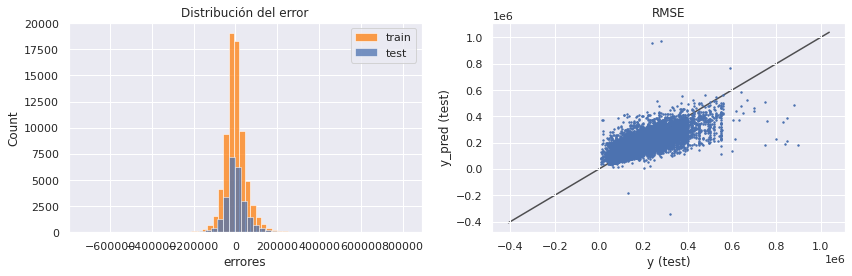

In [328]:
rmse_train_ridge,rmse_test_ridge,rmse_cv_ridge = evaluar_regresion_gon(reg_ridge,X_train_new, X_test_new, y_train, y_test)

**Conclusión**: 
La distribución del error es normal y centrada en 0. El error RMSE aumenta para valores de propiedades que superen los 500000.Esta es una de las mejores aproximaciones que se obtiene, es un modelo que tiene overfitting y podemos interntar mejorar con ridgecv.

#### RIDGE CV 

Bucamos el valor de alpha que minimiza el error

In [569]:
from sklearn.linear_model import RidgeCV

Text(0.05, 0.9, 'alpha que minimiza el error: 10.000')

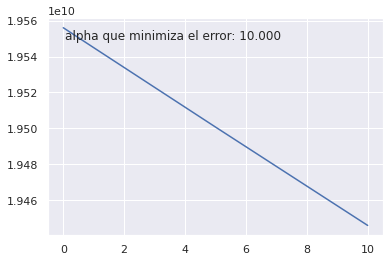

In [570]:
# creamos un numpy array con los valores de alpha que queremos evaluar
rango = (10, 5, 1, 0.5, 0.1 ,0.01, 0.005, 0.001)
# que pasamos a nuestro modelo RidgeCV, guardando los resultados
rcv = RidgeCV(alphas=rango, store_cv_values=True)
rcv.fit(X_train_new, y_train)
# representamos gráficamente el error en función de alpha
plt.rc('text', usetex=False)
f, ax = plt.subplots()
ax.plot(rango, rcv.cv_values_.mean(axis=0))
ax.text(0.05, 0.90, 'alpha que minimiza el error: {:.3f}'.format(rcv.alpha_), transform=ax.transAxes)

In [571]:
reg_ridge = Ridge(alpha = 10)
reg_ridge.fit(X_train_new,y_train)
#print(reg_ridge.coef_, reg_ridge.intercept_)

Ridge(alpha=10)

Raíz del error cuadrático medio en Train: 54394.25048683672
Raíz del error cuadrático medio en Test: 54423.0446173194
Scores cross validation
[54821.43318803265, 58811.85405888503, 305362.1495932291, 57607.71628537672, 54760.782015979225]



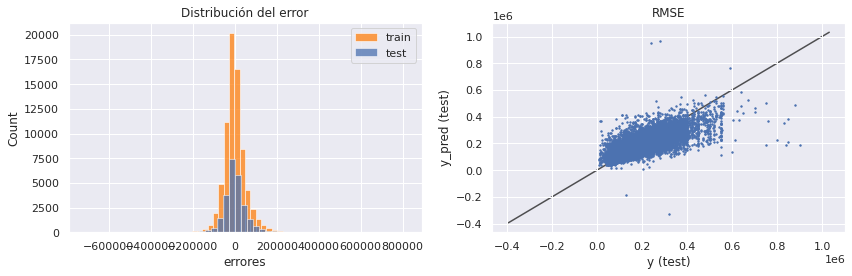

In [572]:
rmse_train_ridge_cv,rmse_test_ridge_cv,rmse_cv_ridge_cv = evaluar_regresion_gon(reg_ridge,X_train_new, X_test_new, y_train, y_test)

**Conlusión**: aparentemente es un buen modelo, pero al pasarle otros conjuntos de datos tiene mucha varianza (Se observa en el cross validation), con lo cual descartaos el modelo.

### Optimización de Hiperparametros (Regularización para disminuir el overfitting) RIDGE CV con PCA

Bucamos el valor de alpha que minimiza el error

In [333]:
from sklearn.linear_model import RidgeCV

Text(0.05, 0.9, 'alpha que minimiza el error: 10.000')

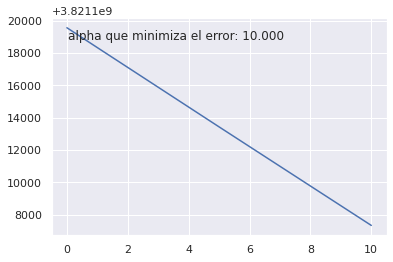

In [334]:
# creamos un numpy array con los valores de alpha que queremos evaluar
rango = (10, 5, 1, 0.5, 0.1 ,0.01, 0.005, 0.001)
# que pasamos a nuestro modelo RidgeCV, guardando los resultados
rcv = RidgeCV(alphas=rango, store_cv_values=True)
rcv.fit(X_train_pca, y_train_pca)
# representamos gráficamente el error en función de alpha
plt.rc('text', usetex=False)
f, ax = plt.subplots()
ax.plot(rango, rcv.cv_values_.mean(axis=0))
ax.text(0.05, 0.90, 'alpha que minimiza el error: {:.3f}'.format(rcv.alpha_), transform=ax.transAxes)

In [335]:
reg_ridge = Ridge(alpha = 10)
reg_ridge.fit(X_train_pca,y_train_pca)
#print(reg_ridge.coef_, reg_ridge.intercept_)

Ridge(alpha=10)

Importancia de las features:

Feature: 0, Score: 27231.23865
Feature: 1, Score: -34088.62436
Feature: 2, Score: 2434.05893
Feature: 3, Score: 22602.13690
Feature: 4, Score: 4498.06986
Feature: 5, Score: 14591.81161
Feature: 6, Score: 18952.01019


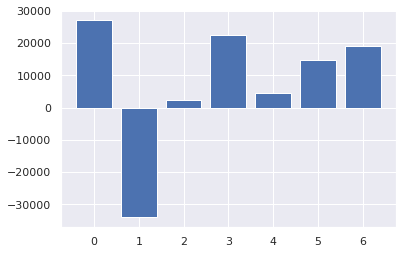

In [336]:
# get importance
importance = reg_ridge.coef_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

Podemos excluir las features 1,2 y 4 para este modelo.

Raíz del error cuadrático medio en Train: 61676.9385276553
Raíz del error cuadrático medio en Test: 61155.11833230111
Scores cross validation
[60527.47197265571, 61472.26634486672, 63699.727009052534, 62769.38783990961, 61001.39928047512]



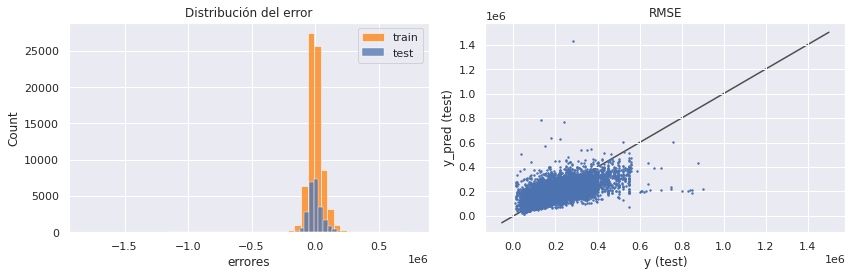

In [337]:
rmse_train_ridge_cv_pca,rmse_test_ridge_cv_pca,rmse_cv_ridge_cv_pca = evaluar_regresion_gon(reg_ridge,X_train_pca, X_test_pca, y_train_pca, y_test_pca)

**Conclusión**: Este es el modelo más estable obtenido hasta este punto, tiene un error más elevado pero no hay alta varianza.

### Modelo SGDRegressor

In [338]:
#Importamos la clase de la librería sklearn
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import cross_val_score

In [339]:
#Definimos el modelo de regresión usando la clase SGDRegresor.
sgdr = SGDRegressor()
#print(sgdr)

Entrenamos el modelo en con los datos de train, y verificamos el accuracy score del modelo

In [340]:
sgdr.fit(X_train, y_train)

score = sgdr.score(X_train, y_train)
print("R-squared:", score)

R-squared: 0.5422900976995396


Aplicamos el método de cross-validation al modelo y chequeamos el accuracy sobre training

In [341]:
cv_score = cross_val_score(sgdr, X, y, cv = 10)
print("CV mean score: ", cv_score.mean())

CV mean score:  0.5191668533768253


Now, we can predict the test data by using the trained model. We can check the accuracy of predicted data by using MSE and RMSE metrics.


Raíz del error cuadrático medio en Train: 61358.2633522627
Raíz del error cuadrático medio en Test: 60943.9694743097
Scores cross validation
[62910.225695684014, 61583.602208260396, 63694.16465496896, 62076.97609467123, 60412.04649203018]



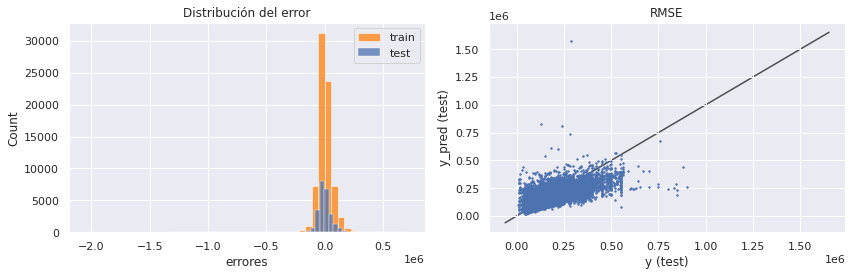

In [342]:
rmse_train_sgdr,rmse_test_sgdr,rmse_cv_sgdr = evaluar_regresion_gon(sgdr,X_train, X_test, y_train, y_test)

El histograma del error de train se observa cierta asimetría, sesgada hacia la izquierda. Esto quiere decir que para el conjunto de train se observan aproximadamente 35000 predicciones (y_test_pred) que tuvieron una predicción mayor al número que teniamos como target (y_test), con lo cual habrá más propiedades sobrevaluadas, no así sobre el conjunto de test que tiene un distribución más simétrica.

El gráfico de RMSE, se observa que el modelo es más preciso para valores de propiedades menores a 400000 luego desde allí comienza a aumentar el error, teniendo propiedades con valores devaluados (el predecido menor al real del target). Ya a partir de 500000 el residuo de los valores se incrementa y así el error en las predicciones. 


**Conclusión**: Es un buen modelo aunque se sigue teniendo un error elevado, no se observa tanta varianza y se podría mejorar jugando con los hiperparametros y/o tratando de hacer un modelo más sencillo ya que hemos usado muchas features.

In [343]:
y_train_pred = sgdr.predict(X_train)
y_test_pred = sgdr.predict(X_test)

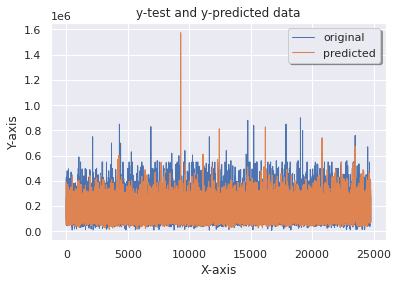

In [344]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, linewidth=1, label="original")
plt.plot(x_ax, y_test_pred, linewidth=1.1, label="predicted")
plt.title("y-test and y-predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 

### SGDRegressor con PCA

Entrenamos el modelo en con los datos de train, y verificamos el accuracy score del modelo

In [345]:
sgdr.fit(X_train_pca, y_train_pca)

score = sgdr.score(X_train_pca, y_train_pca)
print("R-squared:", score)

R-squared: 0.5327911644291358


Aplicamos el método de cross-validation al modelo y chequeamos el accuracy sobre training

In [346]:
cv_score = cross_val_score(sgdr, X, y, cv = 5)
print("CV mean score: ", cv_score.mean())

CV mean score:  0.04625377889819342


Now, we can predict the test data by using the trained model. We can check the accuracy of predicted data by using MSE and RMSE metrics.


Raíz del error cuadrático medio en Train: 61991.6832196659
Raíz del error cuadrático medio en Test: 61500.37231481263
Scores cross validation
[60468.76473009496, 61306.827593504546, 64005.78887660312, 63018.40571368362, 61091.421927157695]



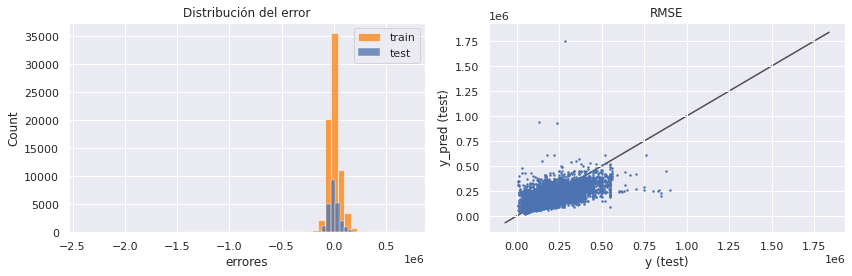

In [347]:
rmse_train_sgdr_pca,rmse_test_sgdr_pca,rmse_cv_sgdr_pca = evaluar_regresion_gon(sgdr,X_train_pca, X_test_pca, y_train_pca, y_test_pca)

Misma observación que en los gráficos del modelo anterior.

Feature: 0, Score: 27701.91292
Feature: 1, Score: -33028.90907
Feature: 2, Score: 6908.05541
Feature: 3, Score: 21464.53412
Feature: 4, Score: 4724.45943
Feature: 5, Score: 20048.52138
Feature: 6, Score: 22223.83157


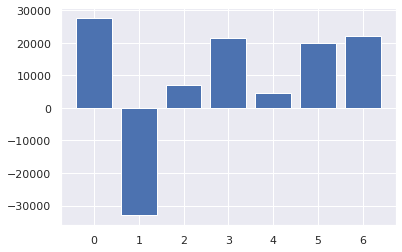

In [348]:
# get importance
importance = sgdr.coef_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

**Conclusión**: Al usar PCA tenemos el mismo preformance que el modelo anterior pero con un modelo mucho mas sencillo. También observamos que las features 1, 2 y 4 no son relevantes para este modelo para realizar la predicción.

Gracicamos test Vs Predict sobre ambos conjunto de datos

In [349]:
y_train_pred = sgdr.predict(X_train_pca)
y_test_pred = sgdr.predict(X_test_pca)

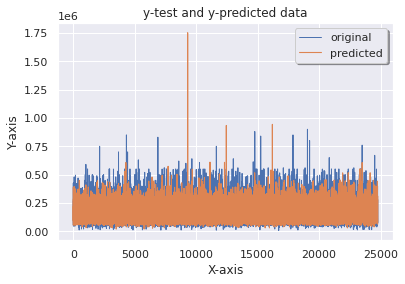

In [350]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, linewidth=1, label="original")
plt.plot(x_ax, y_test_pred, linewidth=1.1, label="predicted")
plt.title("y-test and y-predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 

## **Comparación de los modelos presentados**:

Se crea un dataframe con los datos de error (RMSE) presentado por cada modelo para poder comparar la métrica y elegir el mejor. Se mostrará las columnas
- Model : Nombre del modelo
- rmse_train : Valor del RMSE obtenido para el conjunto train
- rmse_test: Valor del RMSE obtenido para el conjunto test
- rmse_cv: media del valor del RMSE obtenido con Croos Valitation


In [351]:
df_models = []

In [352]:
df_models = pd.DataFrame(columns=['Model','rmse_train', 'rmse_test','rmse_cv'])

In [353]:
models = ['linearRegresion', 'linearRegresion_pca','TreeRegresor', 'TreeRegresor_pca','TreeRegresor_pol','TreeRegresor_pca_rsearch',
         'ridge','ridge_cv','ridge_cv_pca','sgdr','sgdr_pca','RandomForest']

rmse_train =  [rmse_train_linear_model, rmse_train_linear_model_pca,rmse_train_TreeRegresor ,rmse_train_TreeRegresor_pca,rmse_train_TreeRegresor_pol, 
               rmse_train_TreeRegresor_pca_rsearch, rmse_train_ridge, rmse_train_ridge_cv,
               rmse_train_ridge_cv_pca,rmse_train_sgdr, rmse_train_sgdr_pca,rmse_train_TreeRegresor_pca_rforest]

rmse_test =  [rmse_test_linear_model, rmse_test_linear_model_pca,rmse_test_TreeRegresor, rmse_test_TreeRegresor_pca,rmse_test_TreeRegresor_pol,
              rmse_test_TreeRegresor_pca_rsearch, rmse_test_ridge, rmse_test_ridge_cv,
              rmse_test_ridge_cv_pca,rmse_test_sgdr,rmse_test_sgdr_pca,rmse_test_TreeRegresor_pca_rforest]

rmse_cv = [rmse_cv_linear_model, rmse_cv_linear_model_pca,rmse_cv_TreeRegresor,rmse_cv_TreeRegresor_pca,
           rmse_cv_TreeRegresor_pol,rmse_cv_TreeRegresor_pca_rsearch,rmse_cv_TreeRegresor_pca_rforest,
           rmse_cv_ridge,rmse_cv_ridge_cv,rmse_cv_ridge_cv_pca,rmse_cv_sgdr,rmse_cv_sgdr_pca]

In [354]:
df_models['Model'] = models
df_models['rmse_train'] = rmse_train
df_models['rmse_test'] = rmse_test
df_models['rmse_cv'] = rmse_cv

In [355]:
df_models['rmse_train'] = df_models['rmse_train'].astype(int)
df_models['rmse_test'] = df_models['rmse_test'].astype(int)
df_models['rmse_cv'] = df_models['rmse_cv'].astype(int)

In [356]:
df_models = df_models.sort_values(['rmse_test'], ascending=True)
df_models.head(15)

,Model,rmse_train,rmse_test,rmse_cv
11,RandomForest,40994,48272,61978
5,TreeRegresor_pca_rsearch,42329,53120,55277
7,ridge_cv,54394,54423,106143
6,ridge,54393,54437,49763
2,TreeRegresor,26178,54772,56827
3,TreeRegresor_pca,26178,56450,58321
4,TreeRegresor_pol,26178,57698,58656
0,linearRegresion,61017,60486,61485
9,sgdr,61358,60943,61894
1,linearRegresion_pca,61676,61154,61894


##### Graficamos para comparar modelos

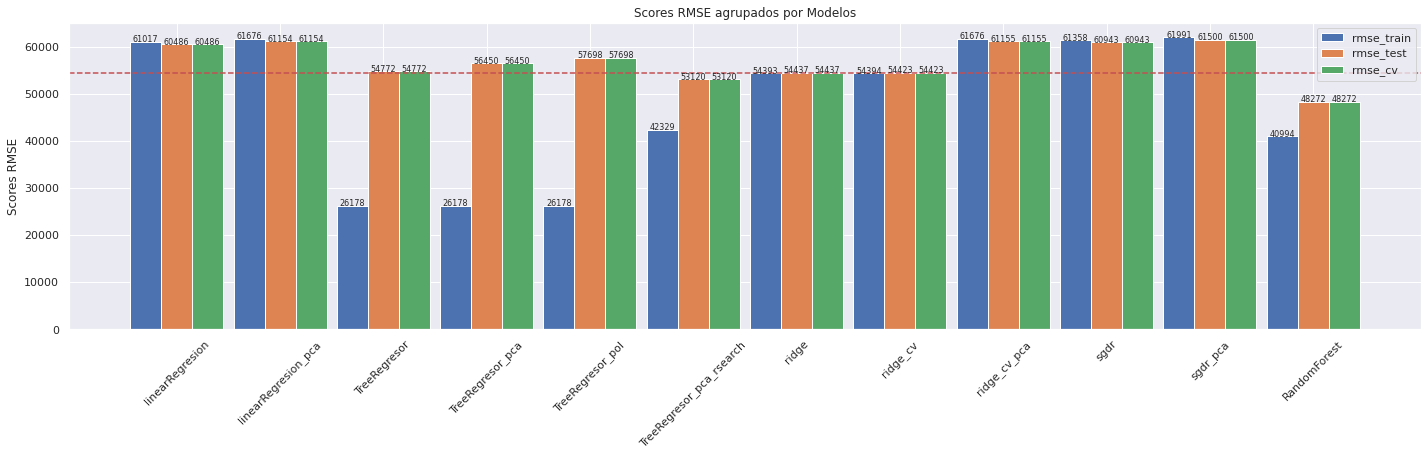

In [357]:
import matplotlib.pyplot as plt
import numpy as np


x = np.arange(len(models))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots(figsize=(20,6.5))

#bar_rmse_train = ax.bar(x - width/2, list(map(int, rmse_train)), width, label='rmse_train')
#bar_rmse_test = ax.bar(x + width/2, list(map(int, rmse_test)), width, label='rmse_test')
#bar_rmse_cv = ax.bar(x + width, list(map(int, rmse_test)), width, label='rmse_cv')
bar_rmse_train = ax.bar(x - width, list(map(int, rmse_train)), width=width, label='rmse_train')
bar_rmse_test = ax.bar(x , list(map(int, rmse_test)), width=width, label='rmse_test')
bar_rmse_cv = ax.bar(x + width, list(map(int, rmse_test)), width=width, label='rmse_cv')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores RMSE')
ax.set_title('Scores RMSE agrupados por Modelos')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45)
ax.legend()

for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 8)
    
#nueva funcion de matplotlib, hay que actualizarla para que muestre el texto, valor en cada barra
#ax.bar_label(bar_rmse_train, padding=3)
#ax.bar_label(bar_rmse_test, padding=3)

plt.axhline(y=54423, color='r', linestyle='--')

fig.tight_layout()

plt.show()

El mejor modelo encontrado es el ridge con cross validation ya que la media de los scores en el cross validation se parece (no hay varianza) con respecto al volor obtenido con la porción de datos usada para test, seguido por SGDRegressor con PCA  que aumenta un 9% el error con respecto al anterior. Todos los modelos de TreeRegresos estuvieron overfiteados, como así RandomForest, se podría probar nuvamente aplicar feature engineering, reducción de dimensionalidad, simplificar el modelo, aplicar regularización, realizar un ajuste de hiperparámetros, y/o conseguir más datos. El modelo de Regrsión Lineal se obtuvieron valores similares a SGDDR.
Además, para mejorar, se podría realizar un modelo para cada región, así filtrando un poco mejor los datos, se probó realizar enconding por frecuencia en las features l3, ya que estas con get_dummies de pandas aumentaron mucho la dimensionalidad.

### Clustering

Se utilizará clustering, k-means, para que agrupe nuestros datos e intentar encontrar relaciones entre las Zonas, Barrio y Tipo de Propiedad en nuestro dataset. Empleamos el método del codo para determinar cuantos clusters emplear en el modelo k-means, luego entrenamos el módelo que el número obenido y sacamos conclusiones.
Finalmente adermimos los datos del cluster a nuestro dateset y volvemos a entrenar un modelo.

In [358]:
# Cargamos el dataset anteriormente Guardado donde se le aplicó Feature Engineering
data = pd.read_csv('df11.csv')
data.head()
print(data.shape)

(99044, 16)


In [359]:
# Escalamos el valor del precio
valor_medio = data['price'].mean()
std = data['price'].std()
data['price'] =  (data['price'] - valor_medio) / std

In [360]:
data.head()

,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,Bs.As. G.B.A. Zona Oeste,Bs.As. G.B.A. Zona Sur,Capital Federal,l3_frec,Casa de campo,Departamento,Lote,Oficina,PH
0,-1.200704,-1.473440,-0.767118,-0.572061,-0.542544,-0.842361,-1.068180,0,0,1,-1.234255,0,1,0,0,0
1,0.660788,0.878208,1.119771,-0.572061,-0.177613,0.069424,0.253406,0,0,1,-1.327281,0,1,0,0,0
2,0.388773,-0.689558,-0.767118,-0.572061,-0.531315,-0.842361,-1.090206,0,0,1,1.297238,0,1,0,0,0
3,0.479888,-1.473440,-1.710562,-0.572061,-0.458329,-0.716114,-0.925008,0,0,1,-1.114823,0,1,0,0,0
4,-0.350077,-0.689558,-0.767118,-0.572061,-0.441486,-0.589867,-0.925008,0,0,1,0.437203,0,1,0,0,0


Aplicamos el método del codo para intentar descubrir el números de Clusters a emplear.

In [361]:
#Importamos Kmeans
from sklearn.cluster import KMeans

#Preparamos una lista donde guardamos las distancias medias
sum_of_squared_distances = []
#Hacemos un fit  para cada modelo y x número de clusters
K = np.arange(2,20)
for k in K:
    #Definimos y entrenamos el modelo
    km = KMeans(n_clusters=k)
    km = km.fit(data)
    #Calculamos la distancia media y la agregamos a la lista
    distancia_total = km.inertia_
    distnacia_media = np.divide(distancia_total,data.shape[0])
    sum_of_squared_distances.append(distnacia_media)

Graficamos

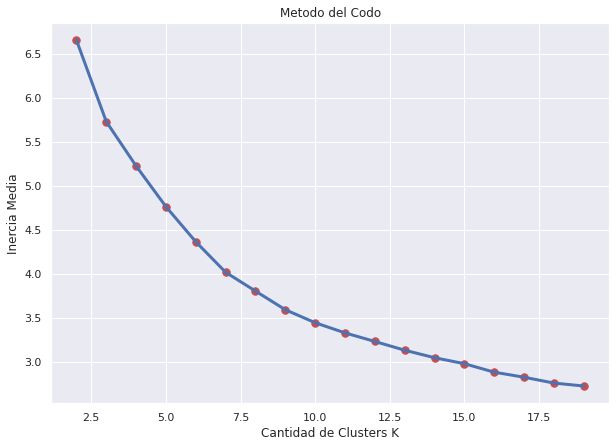

In [362]:
plt.figure(figsize = (10,7))
plt.plot(K, sum_of_squared_distances, lw=3 )
plt.scatter(K, sum_of_squared_distances, s=55, c='r')
plt.xlabel("Cantidad de Clusters K")
plt.ylabel("Inercia Media")
plt.title("Metodo del Codo")
plt.show()

Defino la cantidad de clusters = 8

In [363]:
n_clusters_codo = 8

In [364]:
# Especificamos el numero adecuado de clusters en cada caso
kmeans = KMeans(n_clusters=n_clusters_codo, random_state=0)

In [365]:
# Aplicamos el modelo al dataset (ya procesado y estandarizado)
clusters = kmeans.fit_predict(data)

# Cantidad de clusters y centroides
kmeans.cluster_centers_.shape

(8, 16)

Grafico de cantidad de Instancias por Cluster

In [366]:
md_k = pd.Series(kmeans.labels_)

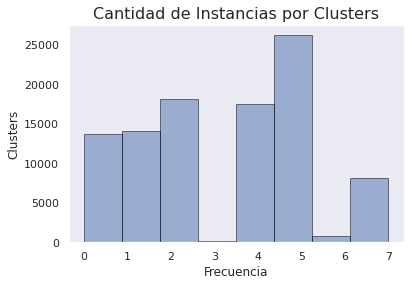

In [367]:
plt.hist(md_k, bins=n_clusters_codo, alpha=0.5, histtype='bar', ec='black')
plt.xlabel('Frecuencia', fontsize=12)
plt.ylabel('Clusters', fontsize=12)
plt.title("Cantidad de Instancias por Clusters", fontsize = 16)
plt.grid()
plt.show()

Se observa que los clusters 3 y 6 tienen muy pocas instancias, con lo cual podríamos considerar descartarlas si usamos estos datos para volver a entrenar alguno de los modelos probados anteriormente y ver resultados.

In [368]:
# Verifico cuantos datos etiquetados por kmeans
etiquetas = kmeans.labels_
print(etiquetas.shape)

(99044,)


In [369]:
# Cuantas tipos de etiquetas, serán la cantidad de clusters
set(etiquetas)

{0, 1, 2, 3, 4, 5, 6, 7}

In [370]:
# Centros de los clusters 
centros = kmeans.cluster_centers_
print(centros)

[[-8.74174892e-01  5.13874909e-01  4.34095376e-01 -1.14517480e-01
   4.41152714e-01  3.50753283e-01 -4.59287427e-01  3.90067328e-01
   4.33866647e-01  1.88228480e-02 -1.38914310e-01  2.60624050e-03
   2.44769420e-01  5.21248100e-03  8.68746833e-04  1.80844132e-01]
 [ 9.58790029e-01  5.01429373e-01  5.21902630e-01  9.02583077e-01
  -5.59800528e-02  9.82647589e-02  1.25331918e+00  6.29464601e-03
   4.05262041e-02  6.89157649e-01  6.37358325e-01 -1.08420217e-16
   8.32590707e-01  1.34380083e-03  9.19442676e-04  7.72331848e-02]
 [ 1.05155929e+00 -6.29630817e-01 -5.90517217e-01 -4.32244196e-01
  -3.40208947e-01 -4.54411257e-01 -1.08431886e-01  5.50388023e-05
   6.05426826e-03  7.32511421e-01  1.09939037e+00 -1.18394877e-16
   9.36375144e-01  1.65116407e-04  3.85271616e-03  4.72232924e-02]
 [-3.52869855e-01  8.91493692e-01  8.37270760e-01  8.01901255e-01
   1.65718225e+01  1.48794147e+00  3.36402523e-01  4.35028249e-01
   2.65536723e-01  5.64971751e-03 -8.00909483e-01  1.00000000e+00
   2.44

Graficamos Precio y Zonas segun las etiquetas

/home/gonperez/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/gonperez/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


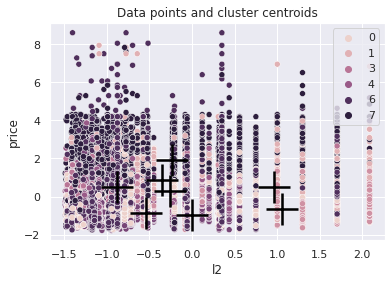

In [371]:
#x = data[:, 0]
#y = data[:, 6]
x = data['l3_frec']
y = data['price']
sns.scatterplot(x, y, hue = etiquetas)
sns.scatterplot(centros[:, 0], centros[:, 1],color='black', marker="+", s=1000)
plt.title('Data points and cluster centroids')
plt.xlabel("l2")
plt.ylabel("price")
plt.show()

No queda claro la definición de clusters, muchos se superponen, es decir que características de una instancia de un cluster también pertence a otro.

#### Agregamos la columna con las etiquetas al dataset

Linkeamos los datos para saber cuales son los barrios que más se parecen según el agrupamientos de Kmeans usando todas las features.

In [372]:
data = pd.DataFrame(data)
labels = pd.DataFrame(etiquetas)
data['label'] = labels

In [373]:
data2 = pd.read_csv('df9.csv')
#data2.head(2)
data2.drop(['title', 'description'], axis=1, inplace=True)
print(data2.shape)

(99044, 12)


In [374]:
data2['clusters'] = labels

In [375]:
data2.head(3)

,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type,dummy_bathrooms,dummy_surface_total,dummy_surface_covered,clusters
0,Capital Federal,Congreso,-1.473440,-0.767118,-0.572061,-0.542544,-0.842361,72000.0,Departamento,1,0,0,5
1,Capital Federal,Villa Ortuzar,0.878208,1.119771,-0.572061,-0.177613,0.069424,192000.0,Departamento,1,0,0,4
2,Capital Federal,Caballito,-0.689558,-0.767118,-0.572061,-0.531315,-0.842361,70000.0,Departamento,1,0,0,2


Agrupamos por clusters y Zonas

In [376]:
data2.groupby(['clusters', 'l2']).size().reset_index(name='counts')

,clusters,l2,counts
0,0,Bs.As. G.B.A. Zona Norte,2161
1,0,Bs.As. G.B.A. Zona Oeste,5386
2,0,Bs.As. G.B.A. Zona Sur,5987
3,0,Capital Federal,259
4,1,Bs.As. G.B.A. Zona Norte,3733
5,1,Bs.As. G.B.A. Zona Oeste,90
6,1,Bs.As. G.B.A. Zona Sur,575
7,1,Capital Federal,9755
8,2,Bs.As. G.B.A. Zona Norte,4751
9,2,Bs.As. G.B.A. Zona Oeste,1


No se observa una definición clara de clusters y l3 (zona), 

#### Analizamos el top 20 de Barrios con mayor número de instancias

In [377]:
value_counts = data2['l3'].value_counts(ascending=True,normalize=False).tail(20)

# converting to df and assigning new names to the columns
df_value_counts = pd.DataFrame(value_counts)
df_value_counts = df_value_counts.reset_index()
df_value_counts.columns = ['unique_values', 'Counts'] # change column names
df_value_counts

,unique_values,Counts
0,General San Martín,1621
1,Lanús,1625
2,Barrio Norte,1737
3,Flores,2104
4,Balvanera,2135
5,Morón,2144
6,Vicente López,2350
7,Pilar,2390
8,Villa Urquiza,2684
9,Villa Crespo,2819


In [378]:
# hacemos una lista con el top 20 de los barrios con mayo numero de instancias
top_l3 = list(df_value_counts['unique_values'])

#### Analizamos los 20 principales barrios por clusters (los que tienen más instancias)

Verificamos cuales son los clusters con mayor número de propiedades/instancias

In [379]:
#Filtramos las 10 localidades con mayor número de propiedades para analizar por tipos de propiedades
df_CAP = data2[(data2.l2 == "Capital Federal")]
df_CAP = df_CAP[(df_CAP.property_type == "Departamento") | (df_CAP.property_type == "Casa") | (df_CAP.property_type == "PH") ]
df_CAP = df_CAP[df_CAP['l3'].isin(top_l3)]

In [380]:
# Cuantaas instancias tiene cada cluster ordenado por barrio
top_l3_clusters = df_CAP.groupby(['clusters'], as_index=False)['l3'].count().sort_values(['l3'], ascending=False).head(20)
top_l3_clusters

,clusters,l3
2,2,12788
1,1,8226
4,5,5344
3,4,5271
6,7,601
0,0,82
5,6,1


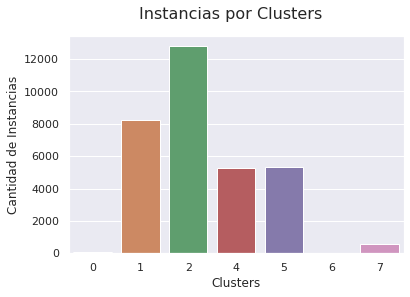

In [381]:
sns.set_theme(style="darkgrid")
ax = sns.barplot(x="clusters", y="l3", data=top_l3_clusters)
plt.suptitle('Instancias por Clusters', fontsize=16)
plt.xlabel("Clusters")
plt.ylabel("Cantidad de Instancias")
plt.show()

Aquí se puede observar lo siguiente, para el filtro aplicado, que los clusters 2,1,5 y 4 reunen la mayor cantidad de instancias. Ahora agrupamos por cluster y barrio para ver cuales son similares:

In [382]:
B = df_CAP.groupby(['clusters','l3']).size()

In [383]:
df_value_counts = pd.DataFrame(B)
df_value_counts = df_value_counts.reset_index()
df_value_counts.columns = ['Clusters','l3', 'Counts'] # change column names
df_value_counts

,Clusters,l3,Counts
0,0,Almagro,7
1,0,Balvanera,39
2,0,Caballito,2
3,0,Flores,28
4,0,Palermo,1
5,0,Villa Crespo,5
6,1,Almagro,407
7,1,Balvanera,13
8,1,Barrio Norte,636
9,1,Belgrano,1606


In [384]:
# En cuantos clusters aparece el barrio
df_value_counts['l3'].value_counts()

Villa Crespo     6
Almagro          6
Flores           6
Balvanera        5
Villa Urquiza    5
Barrio Norte     5
Caballito        5
Recoleta         4
Palermo          4
Belgrano         3
Name: l3, dtype: int64

#### Graficamos el Top 20 de Barrios agrupados por clusters
Para poder visualizar mejor solamente nos quedamos con Capital Federal y los tipos de propiedades con mayor número de instancias.

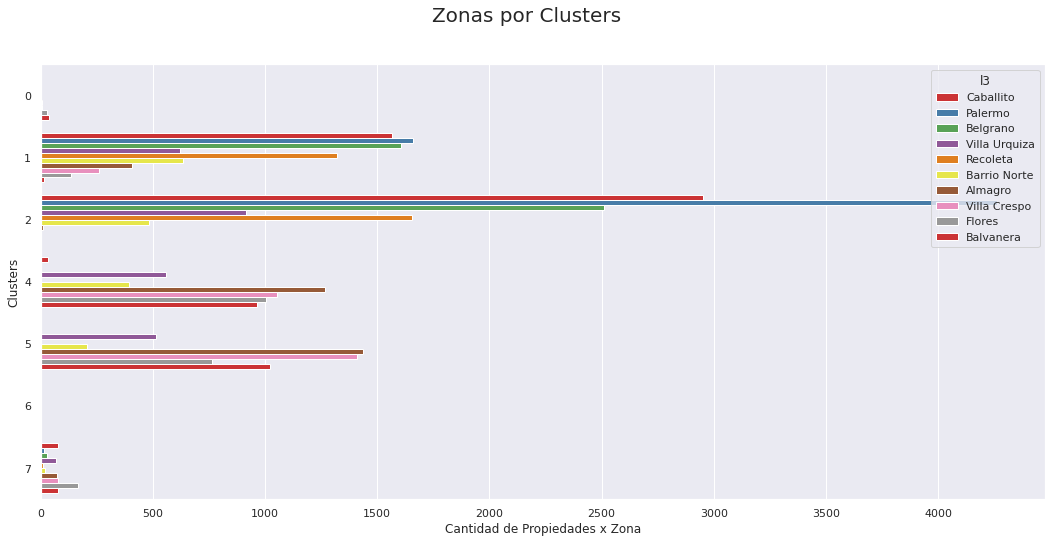

In [385]:
# realizamos agrupamos por Cluster, y realizamos el conteo. El resultado lo cuardamos en un nuevo dataframe "count" y ordenamos por l3 que contiene el valor del conteo y nos quedamos con el top 20
count = df_CAP.groupby(['clusters'], as_index=False)['l3'].count().sort_values(['l3'], ascending=False).head(20)
# renombramos el valor de la columna de l1 por Total
count = count.rename(columns = {'l3': 'Total'}, inplace = False)
#print("Cantidad de propiedades por zonas, top 10 ",count,end='\n')
# Hago un merge con la data original para quedarme sólo con los barrios que están en el top. how="right", me quedo con las coincidencias del dataframe 2 anteriormente creado que machee la columna clusters
df_CAP_top = pd.merge(df_CAP,count, how='right', on=['clusters'])
#print(df_CAP_top.l3.unique())

#df_CAP_top.shape
#, order = df_CAP_top['l3'].value_counts().index
fig, axes = plt.subplots(figsize=(18, 8))
fig.suptitle('Zonas por Clusters', fontsize=20)
axes = sns.countplot(y='clusters', hue="l3", data=df_CAP_top, palette="Set1")
plt.xlabel("Cantidad de Propiedades x Zona")
plt.ylabel("Clusters")
plt.show()

Se observa que hay barrios que pertenecen a más de un cluster, es decir que hay otras características analizadas para separar en clusters y no están claramente separados los clusters por esta variable.

#### Analizamos por Tipo de propiedad

In [386]:
#data2
df_CAP

,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type,dummy_bathrooms,dummy_surface_total,dummy_surface_covered,clusters
2,Capital Federal,Caballito,-0.689558,-0.767118,-0.572061,-0.531315,-0.842361,70000.0,Departamento,1,0,0,2
4,Capital Federal,Almagro,-0.689558,-0.767118,-0.572061,-0.441486,-0.589867,85000.0,Departamento,1,0,0,5
5,Capital Federal,Palermo,-0.689558,-0.767118,-0.572061,-0.390957,-0.533757,232900.0,Departamento,1,0,0,2
10,Capital Federal,Caballito,0.094325,0.176327,-0.572061,-0.362886,-0.393482,150000.0,Departamento,1,0,0,2
12,Capital Federal,Belgrano,-1.473440,-0.767118,-0.572061,-0.525701,-0.800279,75000.0,Departamento,1,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
97365,Capital Federal,Flores,1.662090,1.119771,0.892947,0.619619,1.009264,219000.0,Casa,0,0,0,7
97411,Capital Federal,Flores,1.662090,1.119771,2.357954,0.395047,1.009264,259500.0,Casa,0,0,0,7
97412,Capital Federal,Flores,0.878208,1.119771,2.357954,0.103103,0.237754,310000.0,Casa,0,0,0,7
97438,Capital Federal,Belgrano,2.445973,2.063215,2.357954,0.731906,2.341873,550000.0,Casa,0,1,0,7


In [387]:
# Cuantaas instancias tiene cada cluster ordenado por property_type
top_property_type_clusters = df_CAP.groupby(['clusters'], as_index=False)['property_type'].count().sort_values(['property_type'], ascending=False).head(20)
top_property_type_clusters

,clusters,property_type
2,2,12788
1,1,8226
4,5,5344
3,4,5271
6,7,601
0,0,82
5,6,1


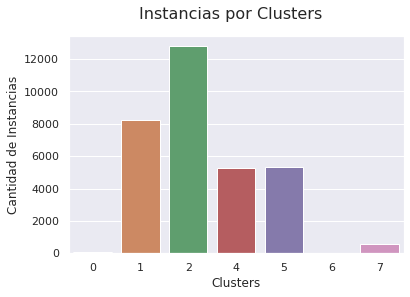

In [388]:
sns.set_theme(style="darkgrid")
ax = sns.barplot(x="clusters", y="property_type", data=top_property_type_clusters)
plt.suptitle('Instancias por Clusters', fontsize=16)
plt.xlabel("Clusters")
plt.ylabel("Cantidad de Instancias")
plt.show()

Los clusters 1 y 7 no tienen propiedades, o un valor insignificante.

In [389]:
# Cantidad de instancias por clusters y tipo propiedad
T = df_CAP.groupby(['clusters','property_type']).size()
# top clusters
lista_top = [1,2,4,5]

In [390]:
df_value_counts = pd.DataFrame(T)
df_value_counts = df_value_counts.reset_index()
df_value_counts.columns = ['Clusters','property_type', 'Counts'] # change column names
#Mostramos solamente los clusters relevantes
df_value_counts[df_value_counts['Clusters'].isin(lista_top)]

,Clusters,property_type,Counts
2,1,Casa,127
3,1,Departamento,7520
4,1,PH,579
5,2,Casa,23
6,2,Departamento,12248
7,2,PH,517
8,4,Casa,48
9,4,Departamento,4561
10,4,PH,662
11,5,Casa,11


#### Graficamos

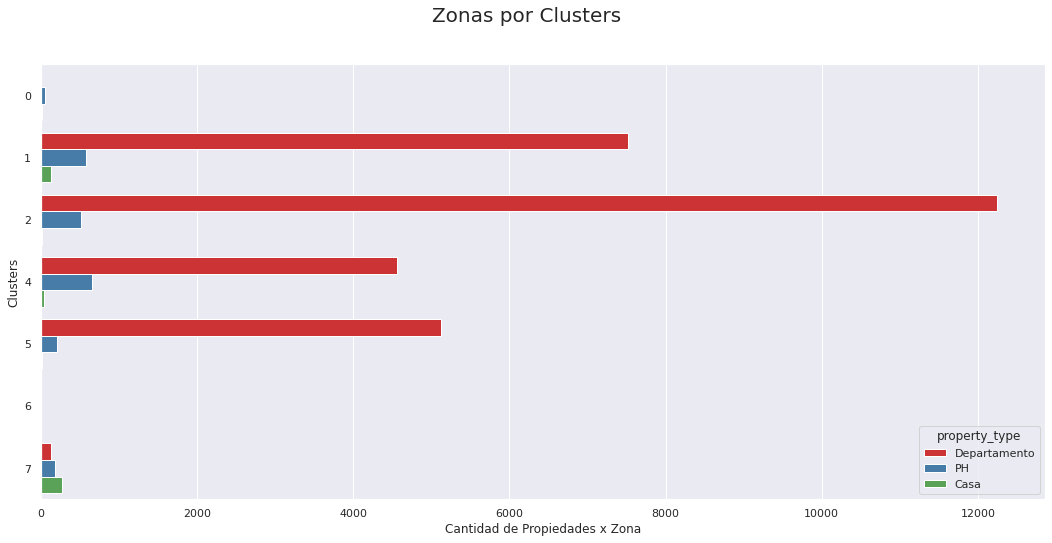

In [391]:
# realizamos agrupamos por Cluster, y realizamos el conteo. El resultado lo cuardamos en un nuevo dataframe "count" y ordenamos por l3 que contiene el valor del conteo y nos quedamos con el top 20
count = df_CAP.groupby(['clusters'], as_index=False)['property_type'].count().sort_values(['property_type'], ascending=False).head(20)
# renombramos el valor de la columna de l1 por Total
count = count.rename(columns = {'property_type': 'Total'}, inplace = False)
#print("Cantidad de propiedades por zonas, top 10 ",count,end='\n')
# Hago un merge con la data original para quedarme sólo con los barrios que están en el top. how="right", me quedo con las coincidencias del dataframe 2 anteriormente creado que machee la columna clusters
df_CAP_top = pd.merge(df_CAP,count, how='right', on=['clusters'])
#print(df_CAP_top.l3.unique())

#df_CAP_top.shape
#, order = df_CAP_top['l3'].value_counts().index
fig, axes = plt.subplots(figsize=(18, 8))
fig.suptitle('Zonas por Clusters', fontsize=20)
axes = sns.countplot(y='clusters', hue="property_type", data=df_CAP_top, palette="Set1")
plt.xlabel("Cantidad de Propiedades x Zona")
plt.ylabel("Clusters")
plt.show()

En los clusters 2 y 5 se observan que los tipos de propiedades Departamento y PH son agrupados en los mismos cluster excluyendo a casa, de igual forma no se puede decir que cada cluster separa a cada tipo de propiedad, ya que por ejemplo departamentos pertenece a los clusters 1,2,4 y 5.

### Usamos los clusters para mejorar los modelos

In [392]:
# Cargamos el dataset anteriormente Guardado donde se le aplicó Feature Engineering
data = pd.read_csv('df11.csv')
data.head()

,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,Bs.As. G.B.A. Zona Oeste,Bs.As. G.B.A. Zona Sur,Capital Federal,l3_frec,Casa de campo,Departamento,Lote,Oficina,PH
0,-1.200704,-1.473440,-0.767118,-0.572061,-0.542544,-0.842361,72000.0,0,0,1,-1.234255,0,1,0,0,0
1,0.660788,0.878208,1.119771,-0.572061,-0.177613,0.069424,192000.0,0,0,1,-1.327281,0,1,0,0,0
2,0.388773,-0.689558,-0.767118,-0.572061,-0.531315,-0.842361,70000.0,0,0,1,1.297238,0,1,0,0,0
3,0.479888,-1.473440,-1.710562,-0.572061,-0.458329,-0.716114,85000.0,0,0,1,-1.114823,0,1,0,0,0
4,-0.350077,-0.689558,-0.767118,-0.572061,-0.441486,-0.589867,85000.0,0,0,1,0.437203,0,1,0,0,0


In [393]:
## Agregamos las etiquetas
data['label'] = labels
data.head()

,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,Bs.As. G.B.A. Zona Oeste,Bs.As. G.B.A. Zona Sur,Capital Federal,l3_frec,Casa de campo,Departamento,Lote,Oficina,PH,label
0,-1.200704,-1.473440,-0.767118,-0.572061,-0.542544,-0.842361,72000.0,0,0,1,-1.234255,0,1,0,0,0,5
1,0.660788,0.878208,1.119771,-0.572061,-0.177613,0.069424,192000.0,0,0,1,-1.327281,0,1,0,0,0,4
2,0.388773,-0.689558,-0.767118,-0.572061,-0.531315,-0.842361,70000.0,0,0,1,1.297238,0,1,0,0,0,2
3,0.479888,-1.473440,-1.710562,-0.572061,-0.458329,-0.716114,85000.0,0,0,1,-1.114823,0,1,0,0,0,5
4,-0.350077,-0.689558,-0.767118,-0.572061,-0.441486,-0.589867,85000.0,0,0,1,0.437203,0,1,0,0,0,5


In [394]:
# Elegimos la data para predecir y el target y
X = data.drop(['price'],axis=1)
y = data['price']

In [395]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Modelo RidgeCV + clusters

Text(0.05, 0.9, 'alpha que minimiza el error: 10.000')

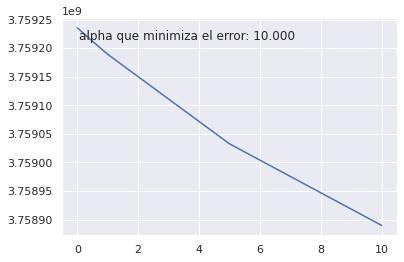

In [396]:
from sklearn.linear_model import RidgeCV,Ridge
from sklearn.model_selection import cross_val_score


# creamos un numpy array con los valores de alpha que queremos evaluar
rango = (10, 5, 1, 0.5, 0.1 ,0.01, 0.005, 0.001)
# que pasamos a nuestro modelo RidgeCV, guardando los resultados
rcv = RidgeCV(alphas=rango, store_cv_values=True)
rcv.fit(X_train, y_train)
# representamos gráficamente el error en función de alpha
plt.rc('text', usetex=False)
f, ax = plt.subplots()
ax.plot(rango, rcv.cv_values_.mean(axis=0))
ax.text(0.05, 0.90, 'alpha que minimiza el error: {:.3f}'.format(rcv.alpha_), transform=ax.transAxes)

In [471]:
reg_ridge = Ridge(alpha = 10)
reg_ridge.fit(X_train,y_train)
#print(reg_ridge.coef_, reg_ridge.intercept_)

Ridge(alpha=10)

Raíz del error cuadrático medio en Train: 60982.24422508084
Raíz del error cuadrático medio en Test: 60471.47895699817
Scores cross validation
[59969.40336492125, 61167.278598632955, 63780.28193057249, 61874.20465072136, 60575.129753012225]



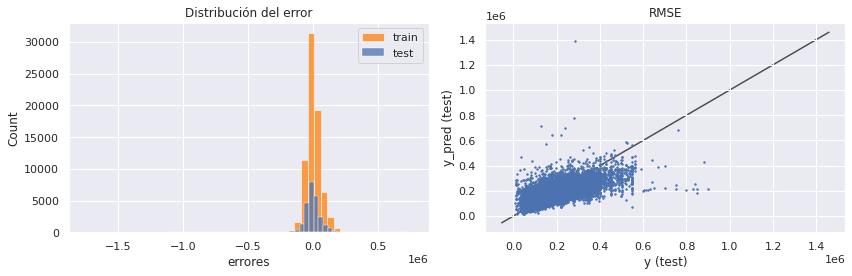

In [472]:
rmse_train_ridge_cv_cluster,rmse_test_ridge_cv_cluster,rmse_cv_ridge_cv_cluster = evaluar_regresion_gon(reg_ridge,X_train, X_test, y_train, y_test)

#### Comparación Modelos "RidgeCV + clusters" Vs "RidgeCV"

In [497]:
df_models_vs_cluster = []

In [498]:
df_models_vs_cluster = pd.DataFrame(columns=['Model','rmse_train', 'rmse_test','rmse_cv'])

In [499]:
models = ['sgdr_pca','sgdr_cluster']

rmse_train_ridge =  [rmse_train_ridge_cv,rmse_train_ridge_cv_cluster]

rmse_test_ridge =  [rmse_test_ridge_cv,rmse_test_ridge_cv_cluster]

rmse_cv_ridge = [rmse_cv_ridge_cv,rmse_cv_ridge_cv_cluster]

In [504]:
df_models_vs_cluster['Model'] = models
df_models_vs_cluster['rmse_train'] = rmse_train_ridge
df_models_vs_cluster['rmse_test'] = rmse_test_ridge
df_models_vs_cluster['rmse_cv'] = rmse_cv_ridge

In [505]:
df_models_vs_cluster['rmse_train'] = df_models_vs_cluster['rmse_train'].astype(int)
df_models_vs_cluster['rmse_test'] = df_models_vs_cluster['rmse_test'].astype(int)
df_models_vs_cluster['rmse_cv'] = df_models_vs_cluster['rmse_cv'].astype(int)

In [506]:
df_models_vs_cluster = df_models_vs_cluster.sort_values(['rmse_test'], ascending=True)
df_models_vs_cluster.head(15)

,Model,rmse_train,rmse_test,rmse_cv
0,sgdr_pca,54394,54423,106273
1,sgdr_cluster,60982,60471,61473


##### Graficamos para comparar modelos

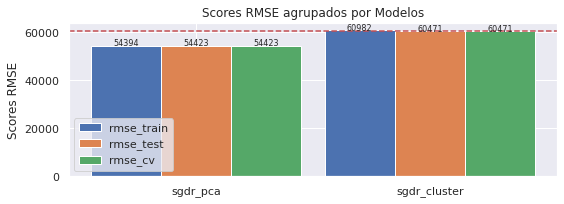

In [508]:
import matplotlib.pyplot as plt
import numpy as np


x = np.arange(len(models))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots(figsize=(8,3))

#bar_rmse_train = ax.bar(x - width/2, list(map(int, rmse_train)), width, label='rmse_train')
#bar_rmse_test = ax.bar(x + width/2, list(map(int, rmse_test)), width, label='rmse_test')
#bar_rmse_cv = ax.bar(x + width, list(map(int, rmse_test)), width, label='rmse_cv')
bar_rmse_train = ax.bar(x - width, list(map(int, rmse_train_ridge)), width=width, label='rmse_train')
bar_rmse_test = ax.bar(x , list(map(int, rmse_test_ridge)), width=width, label='rmse_test')
bar_rmse_cv = ax.bar(x + width, list(map(int, rmse_test_ridge)), width=width, label='rmse_cv')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores RMSE')
ax.set_title('Scores RMSE agrupados por Modelos')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=0)
ax.legend()

for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 8)
    
#nueva funcion de matplotlib, hay que actualizarla para que muestre el texto, valor en cada barra
#ax.bar_label(bar_rmse_train, padding=3)
#ax.bar_label(bar_rmse_test, padding=3)

plt.axhline(y=60471, color='r', linestyle='--')

fig.tight_layout()

plt.show()

**Conclusión**: No se observa mejora al agregar las etiquetas del cluster al dataset, al contrario de lo esperado se introduce un error del 18% al agregarle las etiquetas.

### Modelo SGDRegressor + clusters

In [480]:
#Importamos la clase de la librería sklearn
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import cross_val_score

In [481]:
#Definimos el modelo de regresión usando la clase SGDRegresor.
sgdr = SGDRegressor()
#print(sgdr)

Entrenamos el modelo en con los datos de train, y verificamos el accuracy score del modelo

In [482]:
sgdr.fit(X_train, y_train)

score = sgdr.score(X_train, y_train)
print("R-squared:", score)

R-squared: 0.5007255036040146


Aplicamos el método de cross-validation al modelo y chequeamos el accuracy sobre training

In [483]:
cv_score = cross_val_score(sgdr, X, y, cv = 10)
print("CV mean score: ", cv_score.mean())

CV mean score:  0.5182307436847298


Raíz del error cuadrático medio en Train: 64083.70257675133
Raíz del error cuadrático medio en Test: 63369.83144009504
Scores cross validation
[60101.36276976796, 61712.28800229461, 64661.60042891883, 62059.525976915626, 60441.06169545195]



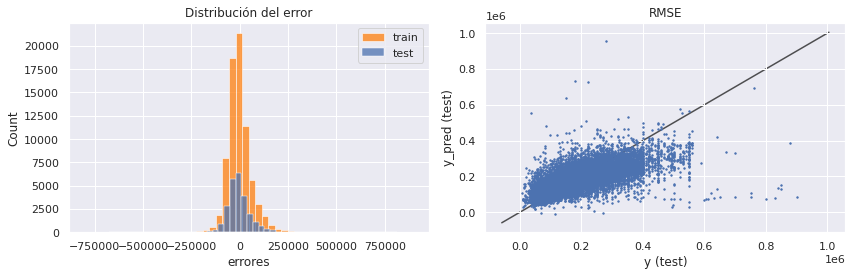

In [484]:
rmse_train_sgdr_cluster,rmse_test_sgdr_cluster,rmse_cv_sgdr_cluster = evaluar_regresion_gon(sgdr,X_train, X_test, y_train, y_test)

#### Comparación Modelos "SGDRegressor + clusters" Vs "SGDRegressor"

In [510]:
df_models_vs_cluster = []

In [511]:
df_models_vs_cluster = pd.DataFrame(columns=['Model','rmse_train', 'rmse_test','rmse_cv'])

In [512]:
models = ['sgdr_pca','sgdr_cluster']

rmse_train_sgdr =  [rmse_train_sgdr_pca,rmse_train_sgdr_cluster]

rmse_test_sgdr =  [rmse_test_sgdr_pca,rmse_test_sgdr_cluster]

rmse_cv_sgdr = [rmse_cv_sgdr_pca,rmse_cv_sgdr_cluster]

In [513]:
df_models_vs_cluster['Model'] = models
df_models_vs_cluster['rmse_train'] = rmse_train_sgdr
df_models_vs_cluster['rmse_test'] = rmse_test_sgdr
df_models_vs_cluster['rmse_cv'] = rmse_cv_sgdr

In [514]:
df_models_vs_cluster['rmse_train'] = df_models_vs_cluster['rmse_train'].astype(int)
df_models_vs_cluster['rmse_test'] = df_models_vs_cluster['rmse_test'].astype(int)
df_models_vs_cluster['rmse_cv'] = df_models_vs_cluster['rmse_cv'].astype(int)

In [515]:
df_models_vs_cluster = df_models_vs_cluster.sort_values(['rmse_test'], ascending=True)
df_models_vs_cluster.head(15)

,Model,rmse_train,rmse_test,rmse_cv
0,sgdr_pca,61991,61500,61978
1,sgdr_cluster,64083,63369,61795


##### Graficamos para comparar modelos

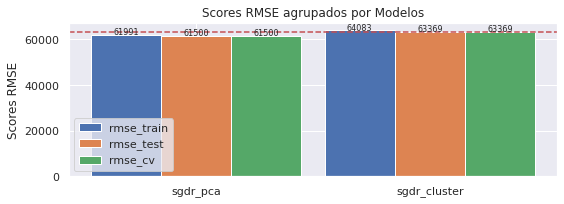

In [517]:
import matplotlib.pyplot as plt
import numpy as np


x = np.arange(len(models))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots(figsize=(8,3))

#bar_rmse_train = ax.bar(x - width/2, list(map(int, rmse_train)), width, label='rmse_train')
#bar_rmse_test = ax.bar(x + width/2, list(map(int, rmse_test)), width, label='rmse_test')
#bar_rmse_cv = ax.bar(x + width, list(map(int, rmse_test)), width, label='rmse_cv')
bar_rmse_train = ax.bar(x - width, list(map(int, rmse_train_vs)), width=width, label='rmse_train')
bar_rmse_test = ax.bar(x , list(map(int, rmse_test_vs)), width=width, label='rmse_test')
bar_rmse_cv = ax.bar(x + width, list(map(int, rmse_test_vs)), width=width, label='rmse_cv')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores RMSE')
ax.set_title('Scores RMSE agrupados por Modelos')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=0)
ax.legend()

for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 8)
    
#nueva funcion de matplotlib, hay que actualizarla para que muestre el texto, valor en cada barra
#ax.bar_label(bar_rmse_train, padding=3)
#ax.bar_label(bar_rmse_test, padding=3)

plt.axhline(y=63369, color='r', linestyle='--')

fig.tight_layout()

plt.show()

#### **Conslusión**:  
No se observaron mejoras al introducir las etiquetas a los datos y volver a utilizar el modelo, incluso se observa que aumenta el error.